<h1 style="font-family: Arial; font-weight: 900; color: magenta; text-align: center;">ENSEMBLE LEARNING</h1><br>

<br/><div style="font-family: Arial; color: darkblue; font-size: 14px; font-weight: 600"><a id="toc"></a>
In this part 7:
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[1. Combining classifiers with majority vote](#1)</p>
        <p style="margin: 0 0 0 4rem">[1a. A simple majority vote classifier](#1a)</p>
        <p style="margin: 0 0 0 4rem">[1b. Evaluating and tuning the ensemble classifier](#1b)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[2. Ensemble learning with bagging](#2)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[3. Adaptive boosting (AdaBoost)](#3)</p>
        <p style="margin: 0 0 0 4rem">[3a. The AdaBoost strategy](#3a)</p>
        <p style="margin: 0 0 0 4rem">[3b. Applying AdaBoost with scikit-learn](#3b)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[4. Gradient Boosting](#4)</p>
        <p style="margin: 0 0 0 4rem">[4a. The Gradient Boosting strategy](#4a)</p>
        <p style="margin: 0 0 0 4rem">[4b. Applying Gradient Boosting with scikit-learn](#4b)</p>
        <p style="margin: 0 0 0 4rem">[4c. scikit-learn's HistGradientBoostingClassifier](#4c)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[Appendix - AdaBoost and Gradient Boosting revisited](#Appendix)</p></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The datasets we will use
from sklearn.datasets import load_iris
df_wine = pd.read_csv('wine.data', header=None)
from sklearn.datasets import make_moons

# Beautify code results using colors
from colorama import Fore, Back, Style
# define some strings for cleaner code
BB = Fore.BLUE + Style.BRIGHT
MB = Fore.MAGENTA + Style.BRIGHT
GB = Fore.GREEN + Style.BRIGHT

# Beautify figures by rendering them in SVG quality instead of JPG
# (don't use this if you prefer lightweight notebooks)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
# we'll use the "cyberpunk" color map
cmap = plt.get_cmap("cool")

<a id="1"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>1. COMBINING CLASSIFIERS WITH MAJORITY VOTE</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1a. A simple majority vote classifier</font><a id="1a"></a></p>$\quad$
        We call <font color='darkpink'>ensemble learning method</font> any machine learning method that combines multiple classifiers. The goal is to achieve a better predictive performance than any individual classifier alone. In this chapter we will focus on the ensembles composed of classifiers that we choose ourselves; we combine their predictions through majority voting, compare the performances of the elements and the ensemble, and look for the better hyperparameters. In the following chapters, we will present a few bagging and boosting algorithms, that combine relatively weak learners (usually shallow trees) to build a strong learner; these individual learners are called the <font color='darkpink'>base learners</font>.<br>$\quad$
        We have already seen an archetypal example of an ensemble learning method : random forests (see part $3$, "4d. Random forests"). The main justification behind ensemble learning methods is, of course, the law of large numbers (or, more precisely, the Condorcet Jury Theorem) : we can get as high an accuracy as needed by training enough independent predictors, each with (slightly) better accuracy than random guessing, and predicting that the class an element belongs to is the class predicted by the majority of predictors. An <font color='#cc33ff'>ensemble learning classifier</font> whose predictions are made according to the majority of its individual predictors is called a <font color='darkpink'>majority vote classifier</font>.<br>$\quad$
        In this part, we will try to improve on this convergence. Our main idea will be to give more weight to our better predictors. More precisely, if there are <font color='#1aabff'>$K$</font> classes and we use <font color='#1aabff'>$p$</font> predictors <font color='#1aabff'>$\,P_1,\cdots,P_p\,$</font>, then any element <font color='#1aabff'>$x$</font> will be predicted to be of class<div style="margin-top: 10px"></div><font color = darkpink>
        $$\hat{y} \;\;=\;\; \underset{k=1,\cdots,K}{\text{argmax}}\;\,\sum_{q=1}^{p}\,w_q \, 1_{\{P_q(x)=k\}} \qquad\quad (1)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$\,1_{\{P_q(x)=k\}}\,$</font> equals $1$ if the <font color='#1aabff'>$q$</font>-th classifier predicts that <font color='#1aabff'>$x$</font> belongs to the class <font color='#1aabff'>$k$</font>, and $0$ otherwise, and where <font color='#1aabff'>$\,w_1,\cdots,w_p\,$</font> are the weights associated with our collection of predictors.<br>$\quad$
        Some classifiers return the probabilities that an element belongs to one class or another (see eg part 3, "2b. The logistic regression strategy"). If we only use this type of classifiers, and if we denote by <font color='#1aabff'>$p_{q,k}(x)$</font> the probability that <font color='#1aabff'>$x$</font> belongs to the class <font color='#1aabff'>$k$</font> according to the classifier <font color='#1aabff'>$P_q$</font>, then we get a more precise version of $(1)$ :<div style="margin-top: 10px"></div><font color = darkpink>
        $$\hat{y} \;\;=\;\; \underset{k=1,\cdots,K}{\text{argmax}}\;\,\sum_{q=1}^{p}\,w_q \, p_{q,k}(x) \qquad\quad (2)$$

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The author proposes to implement both methods and more in his code for a <font color='#5555ff'>MajorityVoteClassifier</font> (see next cell). However, "a more sophisticated version of this majority vote classifier [...] is available in scikit-learn, as sklearn.ensemble.VotingClassifier", so I will use the latter instead.<br>$\quad$
        <font color='#cc33ff'>VotingClassifier(estimators, voting='hard', weights=None, n_jobs=None)</font> is a class from <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>ensemble</font> module, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>estimators</font> : a list of tuples <font color='#5555ff'>('\<$\,$name of the estimator in VotingClassifier$\,$\>', \<$\,$estimator$\,$\>)</font>, each composed of an <font color='#cc33ff'>estimator</font> to use preceded by the name we want it to have in <font color='#cc33ff'>VotingClassifier</font></li>
    <li><font color='#cc33ff'>voting='hard'</font> : specifies whether to use the predicted labels (the default) or the predicted probabilities, "which is recommended for an ensemble of well-calibrated classifiers"</li>
    <li><font color='#cc33ff'>weights=None</font> : specifies the sequence of weights (<font color='#5555ff'>float</font> or <font color='#5555ff'>int</font>) to weigh the occurrences of predicted class labels (hard voting) or class probabilities (soft voting); by default, no weights (ie uniform weights) are used</li>
    <li><font color='#cc33ff'>n_jobs=None</font> : the number of CPU cores to use for parallel execution - <font color='1aabff'>1</font> by default - ; <font color='#cc33ff'>n_jobs=</font>$\,$<font color='1aabff'>-1</font> asks to use all available cores</li></ul><div style="margin-top: 20px"></div>$\quad$
        I have selected the following methods available through <font color='#cc33ff'>VotingClassifier</font> :<ul>
    <li><font color='#cc33ff'>fit(X,y)</font> : trains each individual estimator in the ensemble, independently from one another, so their predictions can later be combined</li>
    <li><font color='#cc33ff'>transform(X)</font> : when <font color='#cc33ff'>voting=</font><font color='1aabff'>'hard'</font>, returns a <font color='#cc33ff'>NumPy</font> array of shape <font color='#5555ff'>(<font color='#1aabff'>$m$</font>, n_estimators)</font>, where <font color='#1aabff'>$m$</font> is the number of instances, <font color='#5555ff'>n_estimators</font> is the number of estimators, and each entry is the label predicted by the corresponding estimator for the corresponding instance; when <font color='#cc33ff'>voting=</font><font color='1aabff'>'soft'</font>, returns a <font color='#cc33ff'>NumPy</font> array of shape <font color='#5555ff'>(<font color='#1aabff'>$m$</font>, n_estimators*n_classes)</font> where <font color='#5555ff'>n_classes</font> is the number of classes, and each row is composed of the predicted class probabilities output by the first estimator, then the second, and so on, for the corresponding instance</li>
    <li><font color='#cc33ff'>fit_transform(X)</font> : equivalent to <font color='#cc33ff'>fit(X,y)</font> followed by <font color='#cc33ff'>transform(X)</font></li>
    <li><font color='#cc33ff'>predict(X)</font> : returns the predicted class labels for each instance of X</li>
    <li><font color='#cc33ff'>score(X, y)</font> : returns the mean accuracy</li>
    <li><font color='#cc33ff'>predict_proba(X)</font> : returns the predicted probabilities of possible outcomes for each instance of X</li>
    <li><font color='#cc33ff'>get_params(deep=True)</font> : returns a dictionary whose keys are the parameter names of the <font color='#cc33ff'>VotingClassifier</font> instance, and whose entries are their values; by default, the dictionary also contains the parameters of its individual estimators and their values (not included when <font color='#cc33ff'>deep=</font><font color='#1aabff'>False</font>). If some of the individual estimators are pipelines - eg containing a <font color='#cc33ff'>MinMaxScaler</font> (see part 4, "3b. Bringing features onto the same scale") -, and <font color='#cc33ff'>deep=</font><font color='#1aabff'>True</font>, then the parameters of the steps of the pipelines are returned - eg <font color='#cc33ff'>feature_range</font> -; and so on : with <font color='#cc33ff'>deep=</font><font color='#1aabff'>True</font>, the parameters of all individual elements are returned, however far nested they are. The names of the parameters are built following the same pattern as <font color='#cc33ff'>param_name</font> in <font color='#cc33ff'>validation_curve</font> (see previous part, "3b. Validation curves") - eg the <font color='#5555ff'>feature_range</font> of a <font color='#cc33ff'>MinMaxScaler</font> called <font color='#5555ff'>scaler</font> inside a pipeline called <font color='#5555ff'>pipe</font> willl be named <font color='#5555ff'>pipe__scaler__feature_range</font> -</li>

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue"><div style="margin-top: 20px"></div>$\quad$
        We begin with the implementation of a <font color='#cc33ff'>majority vote classifier</font> presented in the book :

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'; got (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f"Number of classifiers and weights must be equal"
                f"; got {len(self.weights)} weights, {len(self.classifiers)} classifiers")
        # Use LabelEncoder to ensure class labels start with 0, which is important for np.argmax calls
        # in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote; collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                                            axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Instead of the book's code, we will use the more generic and complete <font color='#cc33ff'>VotingClassifier</font> class presented above. But first, we need a dataset to apply it on; we will use the well-known <font color='#cc33ff'>Iris dataset</font>, introduced in part 1, "2b. Notations". We replace the Iris species names with integers, and then split the dataset into <font color='#cc33ff'>training</font> and <font color='#cc33ff'>test</font> sets with only half of the instances for training (following the book) :<br>

In [3]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# we load the iris dataset directly from scikit-learn
iris = load_iris()
# extracts a portion of the dataset : selects the features from index 1 and 2 (petal length and
# petal width) and ignores the first 50 instances (corresponding to the 'setosa' class)
X, y = iris.data[50:, [1, 2]], iris.target[50:]
# converts the class labels (species names) into numerical labels, a necessary step for some machine
# learning algorithms that can only handle numerical inputs
le = LabelEncoder()
y = le.fit_transform(y)
# randomly splits the data into 50% training and 50% testing sets; 'stratify=y' ensures that the class
# distribution is preserved in both the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Now we choose three different classifiers : a logistic regression classifier, a decision tree and a k-neighbors classifier. And we combine them with <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>VotingClassifier</font>. Then we evaluate the four estimators via <font color='#cc33ff'>10-fold cross-validation</font> (see part 6, "2. 𝑘-fold cross-validation") and <font color='#cc33ff'>ROC AUC</font> (see our previous part, "5c. The receiver operating characteristic (ROC)") on our <font color='#cc33ff'>training set</font>.<br>$\quad$
        We can observe that the ensemble learning method produces the best results.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# for 'LogisticRegression' see part 3, "2g. Overfitting and regularized linear models"
clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
# for 'DecisionTreeClassifier' see part 3, "4c. Example of a decision tree"
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
# for 'KNeighborsClassifier' see part 3, "Appendix - k-nearest neighbors"; here I use 'n_neighbors=2'
# instead of 'n_neighbors=1' as in the book which would yield worse results here but the same decision
# regions in the next section
clf3 = KNeighborsClassifier(n_neighbors=2, p=2)
# scikit-learn's 'Pipeline' expects a list of tuples where each tuple contains a name (string) and an
# object
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
# we combine the three classifiers using "voting='soft'" because we need to predict probabilities in
# order to get the mean and the standard deviation for the ensemble learning method as well
mv_clf = VotingClassifier([('pipe1', pipe1), ('clf2', clf2), ('pipe3', pipe3)], voting='soft',
                          weights=None, n_jobs=None)
all_clf = [pipe1, clf2, pipe3, mv_clf]
clf_labels = ["Logistic regression", "Decision tree", "KNN", "Ensemble learning (majority voting)"]
print(BB + "Mean ROC AUC scores and standard deviations after 10-fold cross-validation" +
      " on the training set :\n" + MB)
# 'zip' takes p arrays of length l and returns the array of length l whose i-th element is the
# p-tuple composed of the i-th element of each array placed in the same order as the arrays
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print(BB + label + "'s ROC AUC: " + MB, round(scores.mean(), 2), "+/-", round(scores.std(), 2))

Mean ROC AUC scores and standard deviations after 10-fold cross-validation on the training set :

Logistic regression's ROC AUC:  0.92 +/- 0.15
Decision tree's ROC AUC:  0.87 +/- 0.18
KNN's ROC AUC:  0.95 +/- 0.15
Ensemble learning (majority voting)'s ROC AUC:  0.97 +/- 0.1


<br><br><div style="font-family: Arial; font-size:14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1b. Evaluating and tuning the ensemble classifier</font><a id="1b"></a></p>$\quad$
        We plot the <font color='#cc33ff'>ROC curves</font> (see section "5c. The receiver operating characteristic (ROC)") of the four classifiers on the <font color='#cc33ff'>test set</font> to compare the <font color='#cc33ff'>ensemble classifier</font>'s performance with those of the individual classifiers on unseen data.

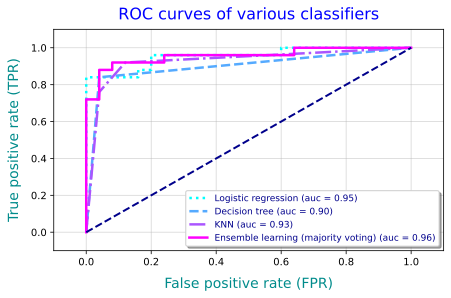

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.figure(figsize=(7, 4))
plt.title("ROC curves of various classifiers", fontsize=16, color='blue', pad=10)
# instead of the colors in the book, which are colors = ['black', 'orange', 'blue', 'green']
# I will use the "cool" cmap, because it yields nicer colors
cmap = plt.get_cmap("cool")
colors = [cmap(i / 3) for i in range(4)]
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # stores the probabilities of belonging to the positive class (class 1) for each element of X_test
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    # 'fpr', 'tpr', and 'thresholds' are the outputs of the ROC curve computation; they are arrays of
    # the same lengths, 'fpr' and 'tpr' being the false positive rates and true positive rates
    # computed at different threshold values, these values being stored in 'thresholds'
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    # computes the AUC using the trapezoidal method
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc = {roc_auc:.2f})', linewidth=2.5)
plt.legend(loc='lower right', fancybox=True, shadow=True, fontsize=9, labelcolor='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='darkblue', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
# adds a grid to the plot with an opacity of 0.5
plt.grid(alpha=0.5)
plt.xlabel("False positive rate (FPR)", labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel("True positive rate (TPR)", labelpad=10, fontsize=14, color='darkcyan')
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We observe that the <font color='#cc33ff'>ensemble classifier</font> performs best on the test set as well.<br>$\quad$
        Now, let's plot the <font color='#cc33ff'>decision boundaries</font> of all four classifiers  :

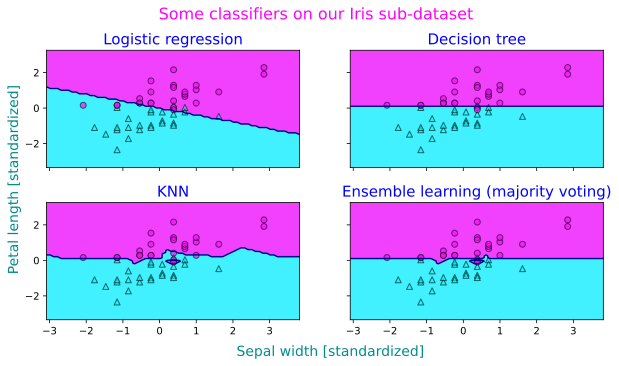

In [6]:
# 'product' computes the cartesian product
from itertools import product

# standardizes the features of the training set (removing the mean and scaling to unit variance)
X_train_std = StandardScaler().fit_transform(X_train)
# computes the minimum value of the first feature of the standardized training set, subtracts 1,
# and assigns it to x_min.
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
# 'np.arange(x_min, x_max, 0.1)' generates an array of values starting from x_min, up to (but not
# including) x_max, with an even step size of 0.1'; 'np.arange(y_min, y_max, 0.1)' is similar
# 'np.meshgrid(...)' takes these two 1D arrays and returns two 2D arrays representing the x and y
# coordinates of all the points in a grid. The resulting xx and yy arrays hold the x and y coordinates,
# respectively, of each point in the grid. 
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# creates a 2x2 grid of subplots which share the 'x' and 'y' axes; 'f' is the figure, while 'axarr' is
# the array of subplots, 'axarr[i,j]' being the subplot at row 'i' and column 'j'
fig, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10, 5))
# idx can be (0,0), (0,1), (1,0) or (1,1); it references the location of the subplot; each subplot
# corresponds to a particular classifier; we build one subplot at a time
for idx, clf, tt in zip(product([0, 1], [0, 1]), [pipe1, clf2, pipe3, mv_clf], clf_labels):
    # the subplot to draw
    ax = axarr[idx[0], idx[1]]
    # fits the classifier
    clf.fit(X_train_std, y_train)
    # The 'ravel()' function flattens multi-dimensional arrays into a one-dimensional array by
    # iterating over the elements of the first row, then the second row, and so on. Then 'np.c_[]'
    # concatenates these sets of coordinates column-wise. At last 'clf.predict()' predicts the class
    # labels for each point in the mesh grid; the points are predicted row by row, starting from the
    # top-left corner and proceeding row by row until the bottom-right corner of the mesh grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # reshapes the 1D array Z back into the shape of the mesh grid (xx.shape), so that it matches the
    # original grid dimensions; note that xx.shape = yy.shape
    Z = Z.reshape(xx.shape)
    # 'contourf(xx, yy, Z, alpha=0.3)' separates the regions where the predicted classes are the same
    # and fills each with a different color (the "f" in 'contourf' means "filled")
    ax.contourf(xx, yy, Z, cmap="cool", alpha=0.8)
    # I add a contour, so the decision boundary between the regions appears more clearly
    ax.contour(xx, yy, Z, levels=[0.5], colors="darkblue")
    # plots the instances of class 0 of the training set; the abscissa (resp. ordinate) of an
    # instance is its value for the first (resp. second) feature; it is colored cyan and marked with
    # triangles pointing upwards of size 50 dots by 50 dots (so its size depends on the DPI)
    ax.scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], marker='^',
                                  color=cmap(0), alpha=0.6, edgecolor='black')
    # plots the instances of class 1 (color: magenta; shape: disks)
    ax.scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], marker='o',
                                  color=cmap(0.999), alpha=0.6, edgecolor='black')
    ax.set_title(tt, fontsize=15, color='blue')

# Position global title and axes' labels manually
fig.subplots_adjust(top=.86, hspace=0.3)
fig.suptitle("Some classifiers on our Iris sub-dataset", fontsize=16, color='magenta')
fig.text(0.52, 0.02, "Sepal width [standardized]", ha='center', va='center', fontsize=14, color='darkcyan')
fig.text(0.08, 0.5, "Petal length [standardized]", ha='center', va='center', fontsize=14, rotation=90, color='darkcyan')
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        As expected, the <font color='#cc33ff'>ensemble classifier</font>'s <font color='#cc33ff'>decision regions</font> appear as a hybrid of those from the individual classifiers.<br>$\quad$
        Before we tune the individual classifier’s parameters for <font color='#cc33ff'>ensemble classification</font>, let’s try the <font color='#cc33ff'>get_params</font> method to see what it returns :

In [7]:
print(MB, mv_clf.get_params())

 {'estimators': [('pipe1', Pipeline(steps=[('sc', StandardScaler()),
                ['clf', LogisticRegression(C=0.001, random_state=1)]])), ('clf2', DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)), ('pipe3', Pipeline(steps=[('sc', StandardScaler()),
                ['clf', KNeighborsClassifier(n_neighbors=2)]]))], 'flatten_transform': True, 'n_jobs': None, 'verbose': False, 'voting': 'soft', 'weights': None, 'pipe1': Pipeline(steps=[('sc', StandardScaler()),
                ['clf', LogisticRegression(C=0.001, random_state=1)]]), 'clf2': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0), 'pipe3': Pipeline(steps=[('sc', StandardScaler()),
                ['clf', KNeighborsClassifier(n_neighbors=2)]]), 'pipe1__memory': None, 'pipe1__steps': [('sc', StandardScaler()), ['clf', LogisticRegression(C=0.001, random_state=1)]], 'pipe1__transform_input': None, 'pipe1__verbose': False, 'pipe1__sc': StandardScaler(), 'pipe1__clf': LogisticRegressio

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Thus, <font color='darkcyan'>mv_clf.get_params</font> returns the hyperparameter values of the three base learners composing <font color='darkcyan'>mv_clf</font>; notably, <font color='#cc33ff'>C=</font><font color='#1aabff'>$0.001$</font> for the <font color='#cc33ff'>logistic regression</font>, a <font color='#cc33ff'>depth</font> of <font color='#1aabff'>$1$</font> for the <font color='#cc33ff'>decision tree</font>, and <font color='#cc33ff'>k=</font><font color='#1aabff'>$2$</font> <font color='#cc33ff'>neighbors</font> for the <font color='#cc33ff'>k-NN</font>.<br>$\quad$
        Let's try some other hyperparameter values, using <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>GridSearchCV</font> (see previous part, "4a. Grid search"), and select the best performing ones.

In [8]:
from sklearn.model_selection import GridSearchCV

# the hyperparameter values that we want to try
params = {'pipe1__clf__C': [0.0001, 0.001, 0.1, 100.0], 'clf2__max_depth': [1, 2],
          'pipe3__clf__n_neighbors': [1, 2]}
# the values are used to look for the best tuning possible of the ensemble estimator 'mv_clf',
# according to the ROC AUC obtained via a 10-fold cross validation
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)
# print the means, the standard deviations, and the corresponding hyperparameters' values
for mean_score, std_dev, params in zip(grid.cv_results_['mean_test_score'],
                                    grid.cv_results_['std_test_score'], grid.cv_results_['params']):
    print(BB, params, MB, round(mean_score, 3), "+/-", round(std_dev, 2))

 {'clf2__max_depth': 1, 'pipe1__clf__C': 0.0001, 'pipe3__clf__n_neighbors': 1}  0.983 +/- 0.05
 {'clf2__max_depth': 1, 'pipe1__clf__C': 0.0001, 'pipe3__clf__n_neighbors': 2}  0.967 +/- 0.1
 {'clf2__max_depth': 1, 'pipe1__clf__C': 0.001, 'pipe3__clf__n_neighbors': 1}  0.983 +/- 0.05
 {'clf2__max_depth': 1, 'pipe1__clf__C': 0.001, 'pipe3__clf__n_neighbors': 2}  0.967 +/- 0.1
 {'clf2__max_depth': 1, 'pipe1__clf__C': 0.1, 'pipe3__clf__n_neighbors': 1}  0.983 +/- 0.05
 {'clf2__max_depth': 1, 'pipe1__clf__C': 0.1, 'pipe3__clf__n_neighbors': 2}  0.967 +/- 0.1
 {'clf2__max_depth': 1, 'pipe1__clf__C': 100.0, 'pipe3__clf__n_neighbors': 1}  0.967 +/- 0.1
 {'clf2__max_depth': 1, 'pipe1__clf__C': 100.0, 'pipe3__clf__n_neighbors': 2}  0.967 +/- 0.1
 {'clf2__max_depth': 2, 'pipe1__clf__C': 0.0001, 'pipe3__clf__n_neighbors': 1}  0.983 +/- 0.05
 {'clf2__max_depth': 2, 'pipe1__clf__C': 0.0001, 'pipe3__clf__n_neighbors': 2}  0.967 +/- 0.1
 {'clf2__max_depth': 2, 'pipe1__clf__C': 0.001, 'pipe3__clf__n_nei

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
       We observe that, in this simple case, using a <font color='#cc33ff'>depth</font> of <font color='#1aabff'>$2$</font> instead of <font color='#1aabff'>$1$</font> for the <font color='#cc33ff'>decision tree</font> and <font color='#1aabff'>$2$</font> <font color='#cc33ff'>neighbors</font> instead of <font color='#1aabff'>$1$</font> for the <font color='#cc33ff'>k-NN</font> is never beneficial and sometimes detrimental. Moreover, the best values for the <font color='#cc33ff'>logistic regression</font>'s <font color='#cc33ff'>regularization parameter</font> correspond to an ultra-strong to strong regularization (<font color='#cc33ff'>C=</font> <font color='#1aabff'>$0.0001$</font>, <font color='#1aabff'>$0.001$</font>, or <font color='#1aabff'>$0.1$</font>; sese part 3, "2g. Overfitting and regularized linear models").

<a id="2"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>2. ENSEMBLE LEARNING WITH BAGGING</font></h4>$\quad$
        As already explained in part 3, "4d. Random forests", we can use <font color='darkpink'>bagging</font> when we want to train many simple predictors (rather than a "perfect" predictor which may lead to overfitting). Instead of using for each predictor all <font color='#1aabff'>$m$</font> instances in our <font color='#cc33ff'>training set</font>, <font color='darkpink'>bagging</font> consists in using still <font color='#1aabff'>$m$</font> instances but randomly chosen with replacement.<br>$\quad$
        These individual datasets are called <font color='darkpink'>bagging round $1$</font>, <font color='darkpink'>bagging round $2$</font>, etc., or <font color='darkpink'>bootstrap sample $1$</font>, <font color='darkpink'>bootstrap sample $2$</font>, etc. Each bootstrap sample generates a predictor, which is our initial predictor but trained on the bootstrap sample. The instances that have not been selected are called the <font color='darkpink'>out-of-bag (oob) instances</font>.<br>$\quad$
        Suppose our problem is a classification problem with <font color='#1aabff'>$k$</font> classes. When we want to estimate the probability that a training instance <font color='#1aabff'>$x$</font> belongs to the class <font color='#1aabff'>$i$</font>, we first select the predictors that do not have <font color='#1aabff'>$x$</font> in their bootstrap sample, and then we compute the mean of the probabilities that <font color='#1aabff'>$x$</font> belongs to class <font color='#1aabff'>$i$</font> according to these predictors; or, if they only return a predicted class for <font color='#1aabff'>$x$</font> (eg they are decision trees), then the predictions are combined using <font color='#cc33ff'>majority voting</font>.<br>$\quad$
        The bootstrap samples of two different simple predictors will most likely be different, reducing overfitting. Also, in average, a proportion of $\left(\frac{m-1}{m}\right)^m$ will not be in a given bootstrap sample; $\left(\frac{m-1}{m}\right)^m$ grows with <font color='#1aabff'>$m$</font> and converges towards $e^{-1}$ ($\simeq 36.8\%$); for example, for $m\!=\!100\,$ the probability that an instance will not be chosen in a bootsrap sample is already $36.6\%$. Thus a bootstrap sample will be composed of roughly two thirds of all the training instances (some repeated). And the probability that <font color='#1aabff'>$x$</font> belongs to class <font color='#1aabff'>$i$</font> according to our ensemble method will be computed as a mean of the results returned by roughly one third of its base learners.<br><br>$\quad$
        A classifier built on the model described here is called a <font color='darkpink'>bagging classifier</font>. They are implemented in <font color='#cc33ff'>scikit-learn</font>, in the <font color='#cc33ff'>ensemble</font> module, under the name <font color='#cc33ff'>BaggingClassifier</font> (see below).<br>$\quad$
        In order to estimate the accuracy of a <font color='#cc33ff'>bagging classifier</font>, we introduce the function which to any training instance <font color='#1aabff'>$x$</font> associates its predicted class. This function is called the <font color='darkpink'>out-of-bag (oob) decision function</font>. We can compare the outcomes of the <font color='#cc33ff'>oob decision function</font> with the true classes; the rate of right predictions is called the <font color='darkpink'>out-of-bag (oob) score</font>; this is not to be confused with the accuracy score, since it only exists on the <font color='#cc33ff'>training set</font>, and whereas the <font color='#cc33ff'>accuracy score</font> is the mean of all the predictions, the <font color='#cc33ff'>oob score</font> only averages the predictions of the classifiers for which the instance is out-of-bag.<br><br>
        <p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='purple'>$\quad$Notes :</font></p><ol>
    <li><font color='#cc33ff'>Random forests</font> are <font color='#cc33ff'>bagging classifiers</font>; they use the bagging technique, together with random features selection, using only $d$ randomly selected features for each individual decision tree (one selection per tree); usually they use $\, d = \sqrt n \,$ features. In contrast here each individual classifier will use the whole set of features; this corresponds to $\, d = n \,$</li>
    <li>Sometimes we may use individual <font color='#cc33ff'>training sets</font> with less than <font color='#1aabff'>$m$</font> instances; we may also choose to not replace the instances when composing these datasets, in which case the method is called <font color='darkpink'>pasting</font></li></ol>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        To see bagging in action, let’s create a more complex classification problem than the one we used in chapter 1. We use instead the <font color='#cc33ff'>wine dataset</font> introduced in part 4, "3a. Partitioning a dataset between a training and a test set". Here, we will only consider the wine classes 2 and 3, and two features - "Alcohol" and "OD280/OD315 of diluted wines" - :

In [9]:
df_wine = pd.read_csv('wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
# drop the first class, class 1
df_wine = df_wine[df_wine['Class label'] != 1]
# selects the column labeled 'Class label' from the DataFrame 'df_wine'; retrieve the values of this
# column as a NumPy array; the result will be called 'y'
y = df_wine['Class label'].values
# similarly, this selects two columns from the DataFrame 'df_wine', retrieves their values as a NumPy
# array and assigns the result to X
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Next, we encode the class labels into binary format and split the dataset into $80\%$ <font color='#cc33ff'>training</font> and $20\%$ <font color='#cc33ff'>test</font> sets :

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 'LabelEncoder' transforms class labels into consecutive integers starting from 0
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Before using <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>BaggingClassifier</font>, I want to introduce it together with some of its parameters. So let's consider a general instance <font color='#cc33ff'>BaggingClassifier(estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None)</font>, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>estimator=None</font> : the type of individual classifiers to use; if <font color='#cc33ff'>None</font>, then these base estimators will be <font color='#cc33ff'>unpruned decision trees</font> (ie <font color='#cc33ff'>fully grown decision trees</font>)</li>
    <li><font color='#cc33ff'>n_estimators=10</font> : the number of base estimators in the ensemble</li>
    <li><font color='#cc33ff'>max_samples=1.0</font> : the number of instances to use to train each <font color='#cc33ff'>base estimator</font>; it is either an integer (to specify the exact number of instances to use), or a float (say <font color='#1aabff'>$p$</font>, in which case the total number of instances to use is <font color='#1aabff'>$p \!\times\! m$</font>)</li>
    <li><font color='#cc33ff'>max_features=1.0</font> : the number of features to use for each predictor; an integer or a float, it works like <font color='#cc33ff'>max_samples</font></li>
    <li><font color='#cc33ff'>bootstrap=True</font> (resp. <font color='#cc33ff'>bootstrap=False</font>) indicates that we want to use a <font color='#cc33ff'>bagging</font> (resp. <font color='#cc33ff'>pasting</font>) method for selecting the individual samples</li>
    <li><font color='#cc33ff'>oob_score=False</font> specifies whether or not to estimate the generalization error; by default, no generalization errors are computed; <font color='#cc33ff'>oob_score=</font><font color='#1aabff'>True</font> means that we want to use out-of-bag samples to estimate the generalization error, and is only available if <font color='#cc33ff'>bootstrap=</font><font color='#1aabff'>True</font></li>
    <li><font color='#cc33ff'>n_jobs=None</font> : the number of CPU cores to use for parallel execution - <font color='1aabff'>1</font> by default - ; <font color='#cc33ff'>n_jobs=</font>$\,$<font color='1aabff'>-1</font> asks to use all available cores</li>
    <li><font color='#cc33ff'>random_state=None</font> : the seed used by the random number generator</li></ul><div style="margin-top: 20px"></div>$\quad$
        If we use an instance of <font color='#cc33ff'>BaggingClassifier</font> with <font color='#cc33ff'>oob_score=</font><font color='#1aabff'>True</font>, then we can retrieve the <font color='#cc33ff'>oob decision function</font> and the <font color='#cc33ff'>oob score</font> : they are the attributes <font color='#cc33ff'>oob_decision_function_</font> and <font color='#cc33ff'>oob_score_</font> of the <font color='#cc33ff'>BaggingClassifier</font> instance, respectively. Otherwise, they are not available.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Now, we define an <font color='#cc33ff'>unpruned decision tree</font> using <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>DecisionTreeClassifier</font> (presented in part 3, "4c. Example of a decision tree'), and we use $500$ of them to define our <font color='#cc33ff'>bagging classifier</font>. Then we will compare the <font color='#cc33ff'>accuracy scores</font> obtained by the single tree and the <font color='#cc33ff'>ensemble classifier</font>.<br>$\quad$
        I also added two <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>default bagging classifiers</font>; they use only $10$ <font color='#cc33ff'>scikit-learn</font>'s default decision trees, ie <font color='#cc33ff'>unpruned trees</font> built with the <font color='#cc33ff'>Gini impurity measure</font>, which is simpler than the <font color='#cc33ff'>entropy</font> used by the author's two classifiers (see part 3, "4b. Building a decision tree"). The first does not compute the <font color='#cc33ff'>oob score</font>, while the second does, just to check that this does not change the predictions, it just gives the possibility to compute the <font color='#cc33ff'>oob score</font>.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

# the classifiers
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0,
                        bootstrap=True, n_jobs=1, random_state=1)
bag1 = BaggingClassifier(n_jobs=1, random_state=1)
bag2 = BaggingClassifier(oob_score=True, n_jobs=1, random_state=1)

# array of (name of classifier, classifier)
classifiers = [
    ("Decision Tree (1 'entropy' fully grown tree)", tree),
    ("Bagging (500 'entropy' trees)", bag),
    ("Default Bagging (10 'gini' trees)", bag1),
    ("Default Bagging with oob_score (10 'gini' trees)", bag2)]

# Iterate through classifiers
for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(BB + "\n", clf_name + " :")
    if clf == bag2: print(GB + "oob score : " + MB, round(clf.oob_score_, 3))
    print(GB + "training accuracy :" + MB, round(train_accuracy, 3))
    print(GB + "test accuracy :" + MB, round(test_accuracy, 3))


 Decision Tree (1 'entropy' fully grown tree) :
training accuracy : 1.0
test accuracy : 0.833

 Bagging (500 'entropy' trees) :
training accuracy : 1.0
test accuracy : 0.917

 Default Bagging (10 'gini' trees) :
training accuracy : 0.979
test accuracy : 0.917

 Default Bagging with oob_score (10 'gini' trees) :
oob score :  0.905
training accuracy : 0.979
test accuracy : 0.917


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can see that the <font color='#cc33ff'>training accuracy</font> was excellent in all cases; we get a slightly better training accuracy for the trees using the <font color='#cc33ff'>entropy impurity measure</font>, but this doesn't translate into better predictions. Also the <font color='#cc33ff'>oob score</font> is less than the accuracy score (this was to be expected since for any instance the oob score only takes into account the predictions made by the classifiers which do not have this instance in their bootstrap samples, which is more difficult than making a prediction on an instance when we know which class it belongs to 😉).<br>$\quad$
        As for the generalization to the <font color='#cc33ff'>test set</font>, the bagging classifiers were all better than the single decision tree. But it does not yield better results to use $500$ trees trained with the <font color='#cc33ff'>entropy measure</font> than $10$ trees trained with the <font color='#cc33ff'>Gini impurity measure</font>. <br><br>$\quad$
        At last, let's compare the <font color='#cc33ff'>decision regions</font> between the <font color='#cc33ff'>decision tree</font> and the <font color='#cc33ff'>bagging classifiers</font> (since I only draw trees here, and since trees don't care about scaling, I reuse my code in cell 6 except that I now replace <font color='#5555ff'>X_train_std</font> with <font color='#5555ff'>X_train</font>) :

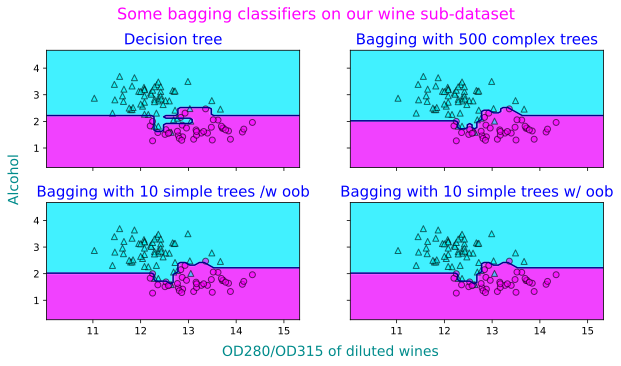

In [12]:
clf_bag_labels = ["Decision tree", "Bagging with 500 complex trees",
                  "Bagging with 10 simple trees /w oob", "Bagging with 10 simple trees w/ oob"]

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

fig, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), [tree, bag, bag1, bag2], clf_bag_labels):
    ax = axarr[idx[0], idx[1]]
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap="cool", alpha=0.8)
    ax.contour(xx, yy, Z, levels=[0.5], colors="darkblue")
    ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], marker='^', color=cmap(0), alpha=0.6, edgecolor='black')
    ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], marker='o', color=cmap(0.999), alpha=0.6, edgecolor='black')
    ax.set_title(tt, fontsize=15, color='blue')
    
fig.subplots_adjust(top=.86, hspace=0.3)
fig.suptitle("Some bagging classifiers on our wine sub-dataset", fontsize=16, color='magenta')
fig.text(0.52, 0.02, "OD280/OD315 of diluted wines", ha='center', va='center', fontsize=14, color='darkcyan')
fig.text(0.08, 0.5, "Alcohol", ha='center', va='center', fontsize=14, rotation=90, color='darkcyan')
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The <font color='#cc33ff'>decision boundaries</font> are smoother for the bagging classifiers than for the single tree, indicating less overfitting. The bagging classifier using <font color='#cc33ff'>oob_score=</font><font color='#1aabff'>False</font> and the one using <font color='#cc33ff'>oob_score=</font><font color='#1aabff'>True</font> have the exact same <font color='#cc33ff'>decision regions</font> 😊.<br><br>$\quad$
        The <font color='#cc33ff'>bagging algorithm</font> is ineffective in reducing <font color='#cc33ff'>model bias</font>, ie it will not yield good results if the <font color='#cc33ff'>base classifiers</font> are overly simple. This is why we use it with <font color='#cc33ff'>low bias classifiers</font>, like <font color='#cc33ff'>unpruned decision trees</font>. Such classifiers tend to overfit the training data, even when the dataset is simple, as we saw in cell 11, and using <font color='#cc33ff'>bagging classifiers</font> mitigates this <font color='#cc33ff'>overfitting</font>. For this very reason, when the datasets are more complex, using <font color='#cc33ff'>bagging classifiers</font> is even more beneficial.

<a id="3"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>3. ADAPTIVE BOOSTING (ADABOOST)</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3a. The AdaBoost strategy</font><a id="3a"></a></p>$\quad$
        <font color='darkpink'>AdaBoost</font> is applied to binary classification tasks. Here, I will denote the classes by <font color='#1aabff'>$-1$</font> and <font color='#1aabff'>$1$</font> to simplify the presentation, although other values are possible, with identical behaviours.<br>$\quad$
        We call <font color='darkpink'>weak learner</font> any simple classifier whose accuracy is slightly better than random guessing; typically it will be a <font color='darkpink'>decision stump</font>, ie a <font color='#cc33ff'>decision tree of depth $1$</font> (which is the default on <font color='#cc33ff'>scikit-learn</font> for their <font color='#cc33ff'>AdaBoostClassifier</font> class - see next subchapter -).<br>
    While the <font color='#cc33ff'>majority vote algorithm</font> and the <font color='#cc33ff'>bagging algorithm</font> may use any type of <font color='#cc33ff'>base learners</font>, the <font color='#cc33ff'>boosting algorithm</font> is only relevant when the <font color='#cc33ff'>base learners</font> are <font color='#cc33ff'>weak learners</font>, as will be apparent after (not before) the presentation of this algorithm (see next subchapter).<br>$\quad$
        We call <font color='darkpink'>boosting algorithm</font> any iterative algorithm based on <font color='#cc33ff'>weak learners</font> with the goal to build a strong predictor; at each round a new <font color='#cc33ff'>weak learner</font> is introduced to try and improve on the predictor under construction.<br>$\quad$
        With <font color='darkpink'>AdaBoost</font>, we use multiple copies of the same <font color='#cc33ff'>weak learner</font>, but they are trained with different cost functions. We first train a <font color='#cc33ff'>weak learner</font>, <font color='#1aabff'>$L_1$</font>, on the <font color='#cc33ff'>training set</font>; if it has perfect accuracy, we stop here and <font color='#1aabff'>$L_1$</font> is our final predictor; having perfect accuracy in our context means that to each instance <font color='#1aabff'>$x^{(i)}$</font> of the <font color='#cc33ff'>training set</font>, <font color='#1aabff'>$L_1(x^{(i)})\,$</font> is a number which is negative if the true label of <font color='#1aabff'>$x^{(i)}$</font> is <font color='#1aabff'>$y^{(i)}=-1$</font>, and positive if <font color='#1aabff'>$y^{(i)}=1$</font>. Usually, <font color='#1aabff'>$L_1$</font> does not have perfect training accuracy, so we want to improve our predictor by adding a new <font color='#cc33ff'>weak learner</font>, <font color='#1aabff'>$L_2$</font>, and a coefficient, <font color='#1aabff'>$\alpha_2$</font>, so that our predictor becomes <font color='#1aabff'>$\,P_2 \,=\, L_1 + \alpha_2 L_2\,$</font>. If <font color='#1aabff'>$P_2$</font> has perfect accuracy, then it is our final classifier, otherwise we add a new <font color='#cc33ff'>weak learner</font>, <font color='#1aabff'>$L_3$</font>, and a new coefficient, <font color='#1aabff'>$\alpha_3$</font>. And so on. We set a maximum number of <font color='#cc33ff'>weak learners</font> to use in order to control the length of this building process; on <font color='#cc33ff'>scikit-learn</font> this maximum number is called <font color='#cc33ff'>n_estimators</font>, and its default value is <font color='#1aabff'>$50$</font>. Here, I will denote by <font color='#1aabff'>$n_e$</font> the maximum number of estimators to use; we use less than <font color='#1aabff'>$n_e$</font> estimators iff we reach a perfect predictor before using our <font color='#1aabff'>$n_e$</font> <font color='#cc33ff'>weak learners</font>. At step <font color='#1aabff'>$\,k=1,\cdots,n_e\,$</font> our predictor is<div style="margin-top: 10px"></div><font color = darkpink>
        $$P_k \;\;=\;\; \sum_{j=1}^k \, \alpha_j \, L_j \qquad\quad (3)$$<font color = darkblue><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$\alpha_1=1$</font>, so <font color='#1aabff'>$\,P_1=L_1\,$</font>.<br>$\quad$
        If <font color='#1aabff'>$P_k$</font> has perfect accuracy then it is our final predictor. Otherwise, knowing everything up to the <font color='#1aabff'>$k$</font>-th step, how do we build <font color='#1aabff'>$P_{k+1}$</font>, ie which cost function should we use for <font color='#1aabff'>$L_{k+1}$</font>, and what value should we give to <font color='#1aabff'>$\alpha_{k+1}$</font> ? The <font color='#cc33ff'>AdaBoost</font> strategy conists in training the new <font color='#cc33ff'>weak learner</font> <font color='#1aabff'>$L_{k+1}$</font> with a cost function which gives more weight to the instances that are wrongly predicted by <font color='#1aabff'>$L_k$</font> and less weight to those that have been correctly predicted by <font color='#1aabff'>$L_k$</font>; thus, <font color='#1aabff'>$L_{k+1}$</font> will try and correct the mistakes of its predecessor.<br><br>$\quad$
        Before being more precise, let's see this idea in action in a simple case with the illustration provided in the book :

<figure style="text-align: center;">
    <img src="7.1. The concept of AdaBoost.png" alt="Figure showing four diagrams on a 2 by 2 grid with decision boundaries to separate two classes represented by blue circles and orange triangles displayed according to two parameters, x_1 and x_2. These diagrams are numbered : the first two (1 and 2) are at the top, and the last two (3 and 4) are at the bottom of the grid. Their descriptions follow below." width="350" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">The concept of AdaBoost</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's describe this illustration of the <font color='#cc33ff'>AdaBoost strategy</font> strategy. Subfigure 1 represents a <font color='#cc33ff'>training set</font> composed of blue circles and orange triangles, where all training instances are assigned <font color='#cc33ff'>equal weights</font>. Based on this <font color='#cc33ff'>training set</font>, we train a <font color='#cc33ff'>decision stump</font> (corresponding to a separating straight line) that tries to classify the examples of the two classes. We get the dashed line shown on the diagram.<br>$\quad$
        For the next round (subfigure 2), we assign a <font color='#cc33ff'>larger weight</font> to the previously <font color='#cc33ff'>misclassified examples</font> (two circles). Furthermore, we lower the weight of the correctly classified examples. The next <font color='#cc33ff'>decision stump</font> will thus be more focused on the training examples that were misclassified by its predecessor. We obtain a new dashed line.<br>$\quad$
        This new <font color='#cc33ff'>weak learner</font> misclassifies three instances from the circle class, which are then assigned a larger weight, as shown in subfigure 3.<br>$\quad$
        Assuming that our <font color='#cc33ff'>AdaBoost ensemble</font> only consists of three <font color='#cc33ff'>rounds of boosting</font>, we then combine the three <font color='#cc33ff'>weak learners</font> using a <font color='#cc33ff'>weighted majority vote</font>, as shown in subfigure 4.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Now that we have a better idea of the process, let's present the <font color='#cc33ff'>AdaBoost algorithm</font> rigorously.<br>$\quad$
        The <font color='#cc33ff'>AdaBoost strategy</font> is an induction. At round <font color='#1aabff'>$k$</font>, we have a set of strictly positive numbers $\{w^{(k)}_i; \; i=1, \cdots, m\}$, called the <font color='darkpink'>instance weights at round $k$</font>. They are obtained by induction, starting with<div style="margin-top: 10px"></div><font color='darkpink'>
        $$w_1^{(1)} \; = \; w_2^{(1)} \;=\; \cdots \;=\; w_m^{(1)} \;=\; \frac{1}{m} \qquad\quad (4)$$</font><div style="margin-top: 10px"></div>$\quad$
        These <font color='#cc33ff'>instance weights</font> allow us to define the cost function <font color='#1aabff'>$J_k$</font> over any predictor <font color='#1aabff'>$L$</font> :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$J_k(L) \;\;=\;\; \sum_{i=1}^{m} \: w_i^{(k)} \, \times \: 1_{\{L(x^{(i)}) \neq y^{(i)} \}} \qquad\quad (5)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$y^{(i)}$</font> is the true class of <font color='#1aabff'>$x^{(i)}$</font>.<div style="margin-top: 20px"></div>$\quad$
        We want <font color='#1aabff'>$L_k$</font> to be the <font color='#cc33ff'>weak learner</font> trained on the <font color='#cc33ff'>training set</font> which minimizes <font color='#1aabff'>$J_k$</font>. It is also the <font color='#cc33ff'>weak learner</font> which minimizes the <font color='darkpink'>weighted error rate at round $k$</font><div style="margin-top: 10px"></div><font color='darkpink'>
        $$r_k \;\;=\;\; \frac{J_k(L_k)}{\sum_{i=1}^{m} w_i^{(k)}} \;\;=\;\; \frac{\sum_{i=1}^{m} \: w_i^{(k)} \, \times \: 1_{\{L_k(x^{(i)}) \neq y^{(i)} \}}}{\sum_{i=1}^{m} w_i^{(k)}} \qquad\quad (6)$$</font><div style="margin-top: 10px"></div>$\quad$
        (in our case the denominators here are equal to $1$; I've kept them for a reason I'll explain in the note below). Since the <font color='#cc33ff'>weights</font> are strictly positive numbers (see below), <font color='#1aabff'>$\,r_k \in [0,1]\,$</font>.<br>$\quad$
        Note that <font color='#1aabff'>$\,r_k = 0\,$</font> would mean that <font color='#1aabff'>$L_k$</font> is a <font color='#cc33ff'>perfect predictor</font>, which is very unlikely at round <font color='#1aabff'>$1$</font>, because we use <font color='#cc33ff'>weak learners</font>, and impossible afterwards, because if one of our <font color='#cc33ff'>weak learners</font> was able to fit the training data perfectly at round <font color='#1aabff'>$k$</font>, it would have done so at the first round as well, and we would have then stopped the building process. Hence it will never happen that our algorithm stops before using all its <font color='#cc33ff'>weak learners</font>, except if it stops at round <font color='#1aabff'>$1$</font>.<br>
    Note also that if <font color='#1aabff'>$\,r_k>\frac{1}{2}\,$</font>, then <font color='#1aabff'>$\,L'_k := -L_k\,$</font> would be a better predictor, with a <font color='#cc33ff'>weighted error rate</font> <font color='#1aabff'>$\,r'_k = 1\!-\!r_k\,$</font>, because then<div style="margin-top: 10px"></div><font color='purple'>
        $$1_{\{L'_k(x^{(i)}) \neq y^{(i)} \}} \;\;=\;\; 1 - 1_{\{L_k(x^{(i)}) \neq y^{(i)} \}} \qquad\quad (7)$$</font><div style="margin-top: 10px"></div>
        Therefore, the best <font color='#cc33ff'>weak learner at round</font> <font color='#1aabff'>$k$</font> has a weighted error rate <font color='#1aabff'>$\, r_k \in ]0,\frac{1}{2}[ \,$</font> (as soon as there is at least one <font color='#cc33ff'>weak learner</font> with a <font color='#cc33ff'>weighted error rate</font> different from $\frac{1}{2}$, which is very likely if our family of weak learners is large enough, eg is the set of all <font color='#1aabff'>stumps</font>).<br>$\quad$
        Using the <font color='#cc33ff'>weighted error rate at round $k$</font> we can now define the <font color='darkpink'>predictor weight at round $k$</font> :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\alpha_k \;\;=\;\; \eta \,.\: \ln \frac{1-r_k}{r_k} \qquad\quad (8)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$\eta$</font> is a strictly positive number called the <font color = darkpink>learning rate</font> (it is equal to $\frac{1}{2}$ in the original <font color='#cc33ff'>AdaBoost presentation</font>, but $1$ is its default value in <font color='#cc33ff'>scikit-learn</font>).<br>
    Since <font color='#1aabff'>$\,r_k \in ]0,\frac{1}{2}[\,$</font>, we have <font color='#1aabff'>$\,\alpha_k>0\,$</font>. Knowing <font color='#1aabff'>$\alpha_k$</font>, <font color='#cc33ff'>AdaBoost</font> defines the <font color='#cc33ff'>instance weights at round</font> <font color='#1aabff'>$(k\!+\!1)$</font> in two steps, by first defining<div style="margin-top: 10px"></div><font color='darkpink'>
        $$w_i^{(k+1)} \;\;=\;\; w_i^{(k)} \, \times \, \exp\left[\, - \alpha_k \,.\, y^{(i)} \,.\, L_k(x^{(i)}) \right] \qquad\quad (9)$$</font><div style="margin-top: 10px"></div>
    which are strictly positive numbers by induction (since the weights are all equal to $\frac{1}{m}$ at round $1$), and then normalizing these quantities to ensure stability as the algorithm progresses :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$w_i^{(k+1)} \;\;:=\;\; \frac{w_i^{(k+1)}}{\sum_{j=1}^{m} w_j^{(k+1)}} \qquad\quad (10)$$</font><div style="margin-top: 10px"></div>
    which are still strictly positive numbers.<br>$\quad$
        Note that with the first step (equation $(9)$), the <font color='#cc33ff'>instance weights</font> <font color='#1aabff'>$\,w_i^{(k+1)}\,$</font> are augmented iff their associated instances were wrongly predicted by <font color='#1aabff'>$L_k$</font>, and diminished iff they were correctly predicted; after normalization (equation $(10)$), the <font color='#cc33ff'>instance weights</font> corresponding to the wrong predictions will still be multiplied by a greater coefficient than the ones that correspond to correct predictions. In this sense, we can say that <font color='#1aabff'>$L_{k+1}$</font> will try and correct the errors of <font color='#1aabff'>$L_k$</font>.<br>$\quad$
        Knowing the instance weights at round <font color='#1aabff'>$k\!+\!1$</font>, we can loop again, define the cost <font color='#1aabff'>$J_{k+1}$</font>, train our weak learner <font color='#1aabff'>$L_{k+1}$</font>,...<div style="margin-top: 20px"></div>$\quad$
        Once all our weak learners have been trained, any instance $x^{(i)}$ will be predicted to be in the class of the same sign as<div style="margin-top: 10px"></div><font color='darkpink'>
        $$P_{n_e}\left(x^{(i)}\right) \;\;=\;\; \sum_{k=1}^{n_e} \, \alpha_k \, L_k\left(x^{(i)}\right) \;\;=\;\; \sum_{k=1}^{n_e} \, \alpha_k \, \left[1_{\{L_k(x^{(i)}) = 1 \}} - 1_{\{L_k(x^{(i)}) = -1 \}}\right] \qquad\quad (11)$$</font><div style="margin-top: 10px"></div>
    Thus, <font color='magenta'>$x^{(i)}$ will be predicted as positive iff the sum of the predictor weights of the weak learners predicting it is positive is larger than the sum of the predictor weights of those predicting it is negative</font>.<br><br>
        <p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='purple'>$\quad$Note :</font></p> $\quad$
        Some texts do not normalize the instance weights at each round (ie use $(9)$ but not $(10)$); and some texts use another formula than $(9)$ (eg "Hands on Machine Learning $[\cdots$]" by A. Géron), although their formula still increases the weights of misclassified instances more than those of correctly classified ones. All texts use all the other formulae presented here, including equation $(6)$ with its denominators; in our case the denominators in $(6)$ are equal to $1$, and the <font color='#cc33ff'>weighted error rate at round</font> <font color='#1aabff'>$k$</font> is the <font color='#cc33ff'>cost of the best weak learner</font> (ie <font color='#1aabff'>$\,r_k = J_k(L_k)\,$</font>).

<br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3b. Applying AdaBoost with scikit-learn</font><a id="3b"></a></p>$\quad$
        Inside its <font color='#cc33ff'>ensemble</font> module, <font color='#cc33ff'>scikit-learn</font> provides the class <font color='#cc33ff'>AdaBoostClassifier(estimator=None, n_estimators=50, learning_rate=1.0, algorithm='deprecated', random_state=None)</font>, where :<ul>
    <li><font color='#cc33ff'>estimator=None</font> : the <font color='#cc33ff'>base estimator</font> from which the boosted ensemble is built; by default, this is the <font color='#cc33ff'>DecisionTreeClassifier(criterion='gini', max_depth=1)</font></li>
    <li><font color='#cc33ff'>n_estimators=50</font> : the maximum number of estimators to use (denoted by <font color='#1aabff'>$n_e$</font> above)</li>
    <li><font color='#cc33ff'>learning_rate=1.0</font> : the learning rate (denoted by <font color='#1aabff'>$\eta$</font> in equation $(8)$)</li>
    <li><font color='#cc33ff'>algorithm='deprecated'</font> : used in the book, it specified the <font color='#cc33ff'>boosting</font> algorithm to follow. <font color='#5555ff'>SAMME.R</font> was the default, but it was deprecated in <font color='#cc33ff'>scikit-learn 1.4</font> and removed in <font color='#cc33ff'>scikit-learn 1.6</font> (the current version). <font color='#5555ff'>SAMME</font> (a generalization of the <font color='#cc33ff'>AdaBoost algorithm</font> presented above to multi-class problems) is now the only remaining option for <font color='#cc33ff'>algorithm</font>. Therefore, <font color='#cc33ff'>algorithm</font> is now useless and deprecated; it will be removed in <font color='#cc33ff'>scikit-learn 1.8</font>. I removed it from the code</li>
    <li><font color='#cc33ff'>random_state=None</font> : the seed of the random number generator used by the <font color='#cc33ff'>base estimators</font> (if they use one)</li></ul>

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let’s now train an <font color='#cc33ff'>AdaBoost ensemble classifier</font> via <font color='#cc33ff'>scikit-learn</font>. We will use the same <font color='#cc33ff'>wine dataset</font> subset that we used in the previous chapter to try a few <font color='#cc33ff'>bagging</font> classifiers.<br>$\quad$
        The author introduces a <font color='#cc33ff'>decision stump</font>, trained with the entropy impurity measure, and an <font color='#cc33ff'>AdaBoost classifier</font> using $500$ of these trees as <font color='#cc33ff'>weak learners</font>. As expected, the <font color='#cc33ff'>AdaBoost classifier</font> performs better than the individual <font color='#cc33ff'>stump</font>, both on the <font color='#cc33ff'>training set</font>, where it gets perfect accuracy, and on the <font color='#cc33ff'>test set</font>.<br>$\quad$
        I added <font color='#cc33ff'>scikit-learn</font>'s default <font color='#cc33ff'>AdaBoost classifier</font>, which only runs <font color='#1aabff'>$50$</font> <font color='#cc33ff'>stumps</font> trained with the simpler <font color='#cc33ff'>'gini' impurity measure</font>, and the predictive results are identical to the ones obtained by the author's <font color='#cc33ff'>AdaBoost classifier</font>. Then, an <font color='#cc33ff'>AdaBoost classifier</font> with only <font color='#1aabff'>$3$</font> of these simpler <font color='#cc33ff'>stumps</font>, with still the same generalization performance, a <font color='#cc33ff'>test accuracy</font> of $91.7\%$, although it fits the training data less closely (with only $93.7\%$ <font color='#cc33ff'>training accuracy</font>). This shows that the dataset used in the book is so simple that even a <font color='#cc33ff'>boosting model</font> with only <font color='#1aabff'>$3$</font> <font color='#cc33ff'>'gini' stumps</font> can predict it as well as the author's model with <font color='#1aabff'>$500$</font> <font color='#cc33ff'>'entropy' stumps</font>. Therefore, I added an appendix to study a slightly more complicated dataset (see at the end of this part).<br>$\quad$
        I also added two single SVM (<font color='#cc33ff'>SVC(kernel=<font color='#1aabff'>'rbf'</font>, gamma=<font color='#1aabff'>30</font>, C=<font color='#1aabff'>100</font>, random_state=<font color='#1aabff'>1</font>)</font> and <font color='#cc33ff'>SVC(kernel=<font color='#1aabff'>'rbf'</font>, gamma=<font color='#1aabff'>30</font>, C=<font color='#1aabff'>10</font>, random_state=<font color='#1aabff'>1</font>)</font>). They perform well on their own (<font color='#cc33ff'>training accuracies</font> of $100\%$ and $98.9\%$ respectively, and both have a <font color='#cc33ff'>test accuracy</font> of $91.7\%$.<br>$\quad$
        It is more relevant to apply the <font color='#cc33ff'>AdaBoost algorithm</font> with <font color='#cc33ff'>weak learners</font> than with <font color='#cc33ff'>strong learners</font>. Indeed, when the <font color='#cc33ff'>base learners</font> are <font color='#cc33ff'>weak learners</font>, the first <font color='#cc33ff'>base learner</font> will wrongly predict many training instances, whether outliers or not, that the second <font color='#cc33ff'>base learner</font> will try to fit. But when the <font color='#cc33ff'>base learners</font> are <font color='#cc33ff'>strong learners</font>, the training instances that the first <font color='#cc33ff'>base learner</font> misclassifies will contain a higher proportion of outliers, to which the second <font color='#cc33ff'>base learner</font> will give more weight; this is the opposite of what we want, which is to try to remove the outliers so that our model generalises well.<br>$\quad$
        It is not possible to reliably use <font color='#cc33ff'>AdaBoostClassifier</font> with <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>SVC</font> as <font color='#cc33ff'>base learners</font>. For example, while using our first <font color='#cc33ff'>SVM</font> as generic <font color='#cc33ff'>base learners</font> for <font color='#cc33ff'>AdaBoostClassifier</font> still yields good results, using our second <font color='#cc33ff'>SVM</font> instead yields very poor results ($63.2\%$ <font color='#cc33ff'>training accuracy</font> and $58.3\%$ <font color='#cc33ff'>test accuracy</font>)...<br>$\quad$
        Otherwise, the results obtained by the <font color='#cc33ff'>boosting classifiers</font> are very similar to the ones we obtained with the <font color='#cc33ff'>bagging classifiers</font> (see cell 11) :

In [13]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# the classifiers
stump = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
# the 'stump' fit is not reused when training the AdaBoost classifiers
ada_3 = AdaBoostClassifier(n_estimators=3, random_state=1)
ada_def = AdaBoostClassifier(random_state=1)
ada_500_entr = AdaBoostClassifier(estimator=stump, n_estimators=500, random_state=1)
svm_c100 = SVC(kernel='rbf', gamma=30, C=100, random_state=1)
ada_svm_c100 = AdaBoostClassifier(estimator=svm_c100, n_estimators=500, learning_rate=0.1)
svm_c10 = SVC(kernel='rbf', gamma=30, C=10, random_state=1)
ada_svm_c10 = AdaBoostClassifier(estimator=svm_c10, n_estimators=500, learning_rate=0.1)

classifiers = [
    ("Decision Tree (1 'entropy' stump)", stump),
    ("small AdaBoost (3 'gini' stumps)", ada_3),
    ("Default AdaBoost (50 'gini' stumps)", ada_def),
    ("large AdaBoost (500 'entropy' stumps)", ada_500_entr),
    ("1 SVM with kernel='rbf', gamma=30, and C=100", svm_c100),
    ("AdaBoost (500 SVM with kernel='rbf', gamma=30, and C=100)", ada_svm_c100),
    ("1 SVM with kernel='rbf', gamma=30, and C=10", svm_c10),
    ("AdaBoost (500 SVM with kernel='rbf', gamma=30, and C=10)", ada_svm_c10)]

for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(BB + "\n", clf_name, GB + ":\ntraining accuracy :" + MB, round(train_accuracy, 3))
    print(GB + "test accuracy :" + MB, round(test_accuracy, 3))


 Decision Tree (1 'entropy' stump) :
training accuracy : 0.916
test accuracy : 0.875

 small AdaBoost (3 'gini' stumps) :
training accuracy : 0.937
test accuracy : 0.917

 Default AdaBoost (50 'gini' stumps) :
training accuracy : 0.979
test accuracy : 0.917

 large AdaBoost (500 'entropy' stumps) :
training accuracy : 1.0
test accuracy : 0.917

 1 SVM with kernel='rbf', gamma=30, and C=100 :
training accuracy : 1.0
test accuracy : 0.917

 AdaBoost (500 SVM with kernel='rbf', gamma=30, and C=100) :
training accuracy : 0.989
test accuracy : 0.917

 1 SVM with kernel='rbf', gamma=30, and C=10 :
training accuracy : 0.989
test accuracy : 0.917

 AdaBoost (500 SVM with kernel='rbf', gamma=30, and C=10) :
training accuracy : 0.632
test accuracy : 0.583


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Finally, let’s visualize the <font color='#cc33ff'>decision regions</font> induced by the <font color='#cc33ff'>AdaBoost classifiers</font> based on our <font color='#cc33ff'>weak learners</font> (<font color='#cc33ff'>decision stumps</font> here). We use a code similar to the one we used in cell 12, but I augmented the resolution by using a tighter <font color='#5555ff'>meshgrid</font> to better capture the <font color='#cc33ff'>decision boundary</font> :

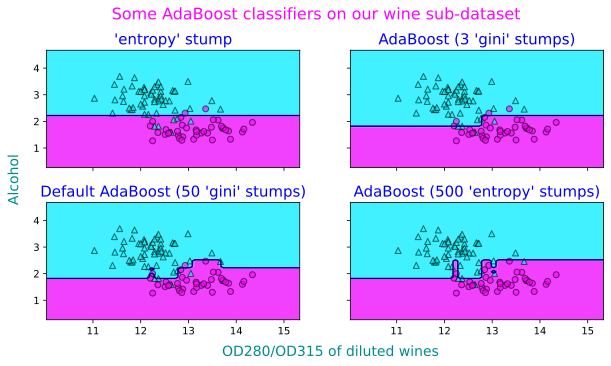

In [14]:
clf_ada_labels = ["'entropy' stump", "AdaBoost (3 'gini' stumps)",
                  "Default AdaBoost (50 'gini' stumps)", "AdaBoost (500 'entropy' stumps)"]

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

fig, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), [stump, ada_3, ada_def, ada_500_entr], clf_ada_labels):
    ax = axarr[idx[0], idx[1]]
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap="cool", alpha=0.8)
    ax.contour(xx, yy, Z, levels=[0.5], colors="darkblue")
    ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], marker='^', color=cmap(0), alpha=0.6, edgecolor='black')
    ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], marker='o', color=cmap(0.999), alpha=0.6, edgecolor='black')
    ax.set_title(tt, fontsize=15, color='blue')
    
fig.subplots_adjust(top=.86, hspace=0.3)
fig.suptitle("Some AdaBoost classifiers on our wine sub-dataset", fontsize=16, color='magenta')
fig.text(0.52, 0.02, "OD280/OD315 of diluted wines", ha='center', va='center', fontsize=14, color='darkcyan')
fig.text(0.08, 0.5, "Alcohol", ha='center', va='center', fontsize=14, rotation=90, color='darkcyan')
plt.show()

<a id="4"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>4. GRADIENT BOOSTING</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4a. The Gradient Boosting strategy</font><a id="4a"></a></p>$\quad$
        The <font color='#cc33ff'>base learners</font> of <font color='darkpink'>gradient boosting</font> classifiers are typically simple <font color='#cc33ff'>trees</font>; this is the only option in <font color='#cc33ff'>scikit-learn</font>. These <font color='#cc33ff'>trees</font> are usually slightly deeper than the typical <font color='#cc33ff'>stumps</font> used in <font color='#cc33ff'>AdaBoost</font>; they have a <font color='#cc33ff'>max_depth</font> of <font color='#1aabff'>$3$</font> by default in <font color='#cc33ff'>scikit-learn</font>. The main difference between these two sets of <font color='#cc33ff'>trees</font>, though, is their goal : while the <font color='#cc33ff'>stumps</font> of the <font color='#cc33ff'>AdaBoost</font> algorithm are trained to correct the mistakes of their predecessor, and the final classifier is a weighted mean of the various <font color='#cc33ff'>stumps</font>, the trees of the <font color='#cc33ff'>gradient boosting</font> algorithm are trained to directly improve the classifier under construction (no mean is computed afterwards) by using the <font color='#cc33ff'>Taylor formula</font> and fitting the <font color='#cc33ff'>trees</font> to some gradient values of the cost function. Therefore, while <font color='#cc33ff'>AdaBoost stumps</font> are classification trees (introduced in part 3, "4. Decision trees and random forests"), the <font color='#cc33ff'>gradient boosting trees</font> must be able to take any real value, they are <font color='darkpink'>regression trees</font>. Therefore, we start this chapter with a real quick presentation of <font color='#cc33ff'>regression trees</font>, just what we need to present the <font color='#cc33ff'>gradient boosting algorithm</font>.

<div style="margin-top: 20px"></div><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <font color='purple'>$\blacksquare\;\,$</font><font size=4><strong><font color='darkpink'>Regression trees</font></strong></font><div style="margin-top: 10px"></div>$\quad$
        Like in the classification case, in practice, only <font color='#cc33ff'>binary regression trees</font> (ie <font color='#cc33ff'>regression trees</font> that split <font color='#cc33ff'>parent nodes</font> in exactly two <font color='#cc33ff'>children nodes</font>) are used. In theory, it is possible to split <font color='#cc33ff'>parent nodes</font> in more than two <font color='#cc33ff'>children</font>, but it would be too demanding computationally to do so. In fact, even considering any possible split in two would be too demanding, and, alike what we do in the classification case, only splits along the feature values are considered.<div style="margin-top: 10px"></div>$\quad$
        Again, starting from our <font color='#cc33ff'>training set</font> <font color='#1aabff'>$X$</font>, we associate to each feature <font color='#1aabff'>$\; X_j \,,\; j=1, \cdots, n \;$</font> the following set <font color='#1aabff'>$\mathcal{H}_j$</font> of hyperplanes :<ol style="margin-top: 5px;">
    <li>we collect and sort the <font color='#1aabff'>$m$</font> values in the column; since some of these values may be equal, we end up with a sequence of the form <font color='#1aabff'>$\; a^{(1)}_j < a^{(2)}_j < \cdots < a^{(p_j)}_j \;$</font>, with <font color='#1aabff'>$\, p_j \leq m \,$</font><div style="margin-top: 5px"></div></li>
    <li>we compute their midpoints <font color='#1aabff'>$\; h^{(k)}_j = \frac{a^{(k)}_j \,+\, a^{(k+1)}_j}{2}\;$</font> for <font color='#1aabff'>$\;k=1,\cdots, p_j\!-\!1 \;$</font><div style="margin-top: 5px"></div></li>
    <li>we use these means as the thresholds for our hyperplanes <font color='#1aabff'>$\mathcal{H}^{(k)}_j = \Big\{x \in \mathbb{R}^n \:;\;\; x_j = h^{(k)}_j \Big\}$</font><div style="margin-top: 5px"></div></li>
    <li><font color='#1aabff'>$\mathcal{H}_j \,=\, \Big\{\mathcal{H}^{(k)}_j \:;\;\; k=1,\cdots, p_j\!-\!1 \Big\}$</font></li></ol>$\quad$
        Once the sets <font color='#1aabff'>$\mathcal{H}_j$</font> have been obtained, we unite them under <font color='#1aabff'>$\; \mathcal{H} \,=\, \bigcup_{j=1}^n \mathcal{H}_j \;$</font>. <font color='#1aabff'>$\mathcal{H}$</font> is the set of all the hyperplanes that the <font color='#cc33ff'>trees</font> will consider to select the best split at the <font color='#cc33ff'>root</font> level. Although these hyperplanes could be used to split all nodes at any level - simply discarding those that became irrelevant in a given node (for example, if a node is split according to <font color='#1aabff'>$\mathcal{H}^{(k)}_j$</font>, then in one child all hyperplanes <font color='#1aabff'>$\mathcal{H}^{(l)}_j$</font> with <font color='#1aabff'>$\, l\!<\!k \,$</font> become irrelevant, while in the other it is those with <font color='#1aabff'>$\, l\!>\!k \,$</font>) - this is not what is done in <font color='#cc33ff'>scikit-learn</font> : the process of collecting and sorting the feature values, and computing their midpoints is redone at each node (possibly for memory management reasons). Anyway, up to now, <font color='#cc33ff'>classification trees</font> and <font color='#cc33ff'>regression trees</font> work the same.<br>$\quad$
        The difference lies in how the "best" split is selected. We have seen in part 3, "4b. Building a decision tree", that <font color='#cc33ff'>classification trees</font> split their nodes by maximizing the <font color='#cc33ff'>information gain</font>, which is based on an <font color='#cc33ff'>impurity measure</font> (eg <font color='#cc33ff'>Gini impurity</font> or <font color='#cc33ff'>entropy</font>), which itself relies on a finite number of classes. As for the <font color='#cc33ff'>regression trees</font>, we will see in our part 9, "3a. Non-linear relationships with decision trees", that the method and vocabulary remain the same, but the <font color='#cc33ff'>impurity measure</font> has a meaning compatible with continuous targets rather than classes. More precisely, the "best" split for a <font color='#cc33ff'>regression tree</font> is the split that minimizes the sum of the <font color='#cc33ff'>impurities</font> of the two children, where the <font color='#cc33ff'>impurity of a node</font> <font color='#1aabff'>$D$</font> is defined as<div style="margin-top: 10px"></div><font color='darkpink'>
        $$I(D) \;=\; \frac{1}{N_D} \;\sum_{x^{(i)}\, \in D}\, \left(y^{(i)}-\hat{y}_D\right)^2 \qquad (12)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$N_D$</font> is the number of instances in <font color='#1aabff'>$D$</font> and<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\hat{y}_D \;=\; \frac{1}{N_D} \;\sum_{x^{(i)} \in D}\, y^{(i)} \qquad (13)$$</font>
    is the mean of the target values of the instances in <font color='#1aabff'>$D$</font>.

<br><div style="margin-top: 20px"></div><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <font color='purple'>$\blacksquare\;\,$</font><font size=4><strong><font color='darkpink'>Multiclass logistic loss function and related notations</font></strong></font><div style="margin-top: 10px"></div>$\quad$
        In the <font color='#cc33ff'>scikit-learn</font> library, there are two variants of the <font color='#cc33ff'>gradient boosting algorithm</font> for classification tasks, <font color='#cc33ff'>GradientBoostingClassifier</font> and <font color='#cc33ff'>HistGradientBoostingClassifier</font>. In both, the only option for the cost function is the <font color='darkpink'>logistic loss function</font> - <font color='darkpink'>$\text{log\_loss}$</font> - (in truth, the first also proposes the loss <font color='#5555ff'>'exponential'</font>, with which "gradient boosting recovers the AdaBoost algorithm" that we studied in the previous chapter). Therefore it is important to start with a clear presentation of the <font color='#cc33ff'>$\text{log\_loss}$</font>. Its original version was for binary classification tasks, but it has been generalized to multiclass problems, and <font color='#cc33ff'>scikit-learn</font> uses both versions accordingly.<br>$\quad$
        We presented in part 3, "2c. The logistic loss function" the original <font color='#cc33ff'>$\text{log\_loss}$ for binary classification tasks</font> :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\text{log\_loss} \;\;=\;\; \frac{1}{m} \, \sum_{i=1}^m \, - \left[ y^{(i)} \, \ln\left(p_i\right) \,+\, {\left(1-y^{(i)}\right)} \ln\left(1-p_i\right) \right] \qquad\quad (14)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$\,p_i, i=1,\cdots,m\,$</font> is the predicted probability that <font color='#1aabff'>$x^{(i)}$</font> belongs to class <font color='#1aabff'>$1$</font>. This is generalized to multiclass problems with <font color='#1aabff'>$\,K\geq3\,$</font> classes :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\text{log\_loss} \;\;=\;\; \frac{1}{m} \, \sum_{i=1}^m \, \sum_{k=0}^{K-1} \, - \left[ y_{ik} \, \ln\left(p_{ik}\right) \right] \qquad\quad (15)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$y_{ik}=1$</font> if <font color='#1aabff'>$x^{(i)}$</font> belongs to the <font color='#1aabff'>$k$</font>-th class and <font color='#1aabff'>$0$</font> otherwise, while <font color='#1aabff'>$p_{ik}$</font> is the predicted probability that <font color='#1aabff'>$x^{(i)}$</font> belongs to the <font color='#1aabff'>$k$</font>-th class.<br>$\quad$
        Therefore, the <font color='#cc33ff'>$\text{log\_loss}$</font> may be used to estimate the quality of any <font color='#cc33ff'>predictor</font> <font color='#1aabff'>$\,P:\mathbb{R}^n \rightarrow \mathbb{R}^K\,$</font> which maps any input <font color='#1aabff'>$\, x \in \mathbb{R}^n \,$</font> to a vector of class probabilities <font color='#1aabff'>$\,\left(p_k(x)\right)_{k=0}^{K-1}\,$</font> where<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\forall x \in \mathbb{R}^n \quad \forall k=0,\cdots,K\!-\!1 \qquad p_k(x) \in\, ]0,1[ \qquad\text{ and }\qquad \forall x \in \mathbb{R}^n \qquad \sum_{k=0}^{K-1} \; p_k(x) \;=\; 1 \qquad\quad (16)$$</font><div style="margin-top: 10px"></div>$\quad$
        We can ensure that <font color='#1aabff'>$\, P=\left(p_k\right)_{k=0}^{K-1} \,$</font> statisfies the conditions $(16)$ by writing its component functions <font color='#1aabff'>$p_k$</font> as the <font color='darkpink'>softmax</font> of some functions <font color='#1aabff'>$\, f_k,\; k=1,\cdots,K \,$</font> with no restrictions except that they map $\mathbb{R}^n$ to $\mathbb{R}$ :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\forall k=0,\cdots,K\!-\!1 \quad \forall x \in \mathbb{R}^n \qquad p_k(x) \;=\; \frac{e^{f_k(x)}}{\sum_{k=0}^{K-1}\; e^{f_k(x)}} \qquad\quad (17)$$</font><div style="margin-top: 10px"></div>$\quad$
        Indeed, if <font color='#1aabff'>$p_k$</font> exist that satisfy $(16)$, then there exist functions <font color='#1aabff'>$f_k$</font> such that the <font color='#1aabff'>$p_k$</font> can be written as in $(17)$; simply take<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\forall k=0,\cdots,K\!-\!1 \quad \forall x \in \mathbb{R}^n \qquad f_k(x) \;=\; \ln\left(p_k(x)\right) \qquad\quad (18)$$</font><div style="margin-top: 10px"></div>
    and conversely, written as in $(17)$, it is clear that the <font color='#1aabff'>$p_k$</font> satisfy $(16)$.<br>$\quad$
        We then extend the notations in $(15)$ by defining<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\forall i=1,\cdots,m \quad \forall k=0,\cdots,K\!-\!1 \qquad f_{ik} \;=\; f_k\!\left(x^{(i)}\right) \qquad\quad (19)$$</font><div style="margin-top: 10px"></div>$\quad$
        For any <font color='#1aabff'>$k=0,\cdots,K\!-\!1$</font>, <font color='#1aabff'>$f_k$</font> is called the <font color='darkpink'>$k$-th logit function</font>. Via $(17)$ and $(18)$, knowing <font color='#1aabff'>$\, P=\left(p_0,\cdots,p_{K-1}\right) \,$</font> is equivalent to knowing <font color='#1aabff'>$\, F=\left(f_0,\cdots,f_{K-1}\right) \,$</font>; <font color='#1aabff'>$F$</font> is called the <font color='darkpink'>logit vector</font>. Moreover, using pointwise operations, <font color='#1aabff'>$\; P(X)=\left(p_{ik}\right)_{i=1\,,\,k=0}^{m\,,\,K-1} \;$</font> and <font color='#1aabff'>$\; F(X)=\left(f_{ik}\right)_{i=1\,,\,k=0}^{m\,,\,K-1} \;$</font>; <font color='#1aabff'>$F(X)$</font> is called the <font color='darkpink'>logit matrix</font>.<br>$\quad$
        Using $(15)$, $(17)$ and $(19)$, the <font color='#cc33ff'>$\text{log\_loss}$</font> can be written as a function of <font color='#1aabff'>$F(X)$</font>; from $(15)$, we infer<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\text{log\_loss}(F(X)) \;\;=\;\; \frac{1}{m} \; \sum_{i=1}^m \, \sum_{k=0}^{K-1} \; \left[ y_{ik}\,\ln\!\left(\sum_{k=0}^{K-1}\, e^{f_{ik}}\right) - y_{ik}\,f_{ik} \right] \;\;=\;\; \frac{1}{m} \; \sum_{i=1}^m \; \left[ \ln\!\left(\sum_{k=0}^{K-1}\, e^{f_{ik}}\right) - \sum_{k=0}^{K-1} \, y_{ik}\,f_{ik} \right] \qquad\quad (20)$$</font><div style="margin-top: 10px"></div>
    because <font color='#1aabff'>$\,\sum_{k=0}^{K-1}\, y_{ik} = 1\,$</font>. Consequently<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\forall i=1,\cdots,m \quad \forall k=0,\cdots,K\!-\!1 \qquad \frac{\partial\, \text{log\_loss}(F(X))}{\partial f_{ik}} \;\;=\;\; \frac{1}{m} \; \left(p_{ik}-y_{ik} \right) \qquad\quad (21)$$</font><div style="margin-top: 10px"></div>$\quad$
        After a few notes about the <font color='#cc33ff'>binary classification</font> case, we will present the <font color='#cc33ff'>gradient boosting algorithm</font>.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='purple'>$\quad$Notes :</font></p><ol>
    <li>Here, I have only considered the case <font color='#1aabff'>$\,K\geq3\,$</font>. The <font color='#cc33ff'>binary classification</font> case is very similar, but slightly different. Since the <font color='#cc33ff'>gradient boosting algorithm</font> can be applied to both situations, I now present the case <font color='#1aabff'>$\,K=2\,$</font>, folowing what we did when <font color='#1aabff'>$\,K\geq3\,$</font>. There are two differences. The first is that, in the <font color='#cc33ff'>binary classification</font> case, we don't have vectors with index <font color='#1aabff'>$k$</font> : the vector of class probabilities <font color='#1aabff'>$P$</font> is reduced to <font color='#1aabff'>$\,P(x)=p(x)\,$</font>, the probability that <font color='#1aabff'>$x$</font> belongs to class <font color='#1aabff'>$1$</font>; similarly, <font color='#1aabff'>$\,F=f\,$</font> and <font color='#1aabff'>$\,f_i=f(x^{(i)}\,$</font>. The other difference is that <font color='#1aabff'>$P$</font> is not the <font color='#cc33ff'>softmax</font> of <font color='#1aabff'>$F$</font>, but the <font color='#cc33ff'>sigmoid</font> of <font color='#1aabff'>$F$</font>. These differences imply that equations $(17)$ to $(21)$ have another version in the <font color='#cc33ff'>binary classification</font> case :<ul><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \forall x \in \mathbb{R}^n \qquad p(x) \;=\; \sigma\left(f(x)\right) = \frac{1}{1+e^{-f(x)}} \qquad\quad (17')$</font></li><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \forall x \in \mathbb{R}^n \qquad f(x) \;=\; \ln\left(\frac{p(x)}{1-p(x)}\right) \qquad\quad (18')$</font></li><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \forall i=1,\cdots,m \qquad f_i \;=\; f\!\left(x^{(i)}\right) \qquad\quad (19')$</font></li><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \text{log\_loss}(F(X)) \;=\; \frac{1}{m} \; \sum_{i=1}^m \; - \left[ y^{(i)}\,\ln\!\left(\frac{1}{1+e^{-f_i}}\right) + \left(1\!-\!y^{(i)}\right)\,\ln\!\left(1\!-\!\frac{1}{1+e^{-f_i}}\right) \right] \;=\; \frac{1}{m} \; \sum_{i=1}^m \; \left[ y^{(i)}\,\ln\!\left(1+e^{-f_i}\right) + \left(1\!-\!y^{(i)}\right)\,\ln\!\left(1+e^{f_i}\right) \right] \qquad\quad (20')$</font></li><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \forall i=1,\cdots,m \qquad \frac{\partial\, \text{log\_loss}(F(X))}{\partial f_i} \;=\; \frac{1}{m} \; \left[ y^{(i)}\,\frac{-e^{-f_i}}{1+e^{-f_i}} + \left(1-y^{(i)}\right)\,\frac{e^{f_i}}{1+e^{f_i}} \right] \;=\; \frac{1}{m} \; \left[ \frac{1}{1+e^{-f_i}} - y^{(i)} \right] \;=\; \frac{1}{m} \; \left(p_i-y^{(i)}\right) \qquad\quad (21')$</font></li><div style="margin-top: 10px"></div></ul></li>
    <li>In <font color='#cc33ff'>multinomial logistic regression</font>, we use the affine logits <font color='#1aabff'>$\, f_k(x) = w_k.x+b_k \,$</font> (<font color='#1aabff'>$\forall k=0,\cdots,K\!-\!1$</font>), where <font color='#1aabff'>$w_k$</font> is a weight and <font color='#1aabff'>$b_k$</font> is a bias; and the vector of class probabilities is the <font color='#cc33ff'>softmax</font> of these logits. While in <font color='#cc33ff'>binary logistic regression</font>, we use <font color='#1aabff'>$\, f(x)=w.x+b \,$</font>, but the probability is the <font color='#cc33ff'>sigmoid</font> of this logit, ie <font color='#1aabff'>$\, p(x)=\sigma(f(x)) \,$</font> (see part 3, "2d. The Hessian of the logistic loss function", equation $(10)$)</li>

<div style="margin-top: 20px"></div><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <font color='purple'>$\blacksquare\;\,$</font><font size=4><strong><font color='darkpink'>The gradient boosting algorithm</font></strong></font><div style="margin-top: 10px"></div>$\quad$
        <font color='#cc33ff'>Gradient boosting</font> applies to a wide range of problems, including <font color='#cc33ff'>regression tasks</font>, in which case the <font color='#cc33ff'>cost function</font> cannot be the <font color='#cc33ff'>$\text{log\_loss}$</font> (it will often be the <font color='#cc33ff'>$MSE\,$</font> instead). However, here, we only consider <font color='#cc33ff'>classification tasks</font>, so our cost function will be the <font color='#cc33ff'>$\text{log\_loss}$</font>.<br>$\quad$
        Let's now present the corresponding algorithm. At step $0$, the <font color='#cc33ff'>gradient boosting algorithm</font> is an induction. After initialization, each step improves on the previous classifier; but instead of improving the classifier directly, the new classifier is obtained via its updated <font color='#cc33ff'>logit vector</font>.<div style="margin-top: 20px"></div>$\quad$
        <font color='magenta'>$\blacklozenge\;$Initialization :</font> The <font color='#cc33ff'>gradient boosting algorithm</font> assumes that the probability that an instance <font color='#1aabff'>$x$</font> belongs to the <font color='#1aabff'>$k$</font>-th class is the proportion of instances of class <font color='#1aabff'>$k$</font> in the training set :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\forall x \in \mathbb{R}^n \quad \forall k=0,\cdots,K\!-\!1 \qquad p^{(0)}_k(x) \;=\; \frac{m_k}{m} \quad\text{ and }\quad f^{(0)}_k(x) \;=\; \ln\!\left(\frac{m_k}{m}\right) \qquad\quad (22)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$m_k$</font> is the number of instances belonging to class <font color='#1aabff'>$k$</font>. That <font color='#1aabff'>$\,f_k(x)=\ln\!\left(\frac{m_k}{m}\right)\,$</font> follows from equation $(18)$.<br>$\quad$
        Thus, our predictor <font color='#1aabff'>$P^{(0)}$</font> has the <font color='#cc33ff'>logit matrix</font> <font color='#1aabff'>$\; F^{(0)}(X)=\left(f^{(0)}_{ik}\right)_{i=1\,,\,k=0}^{m\,,\,K-1} \,$</font> with coefficients<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\forall i=1,\cdots,m \quad \forall k=0,\cdots,K\!-\!1 \qquad f^{(0)}_{ik} \;=\; \ln\!\left(\frac{m_k}{m}\right) \qquad\quad (23)$$</font><div style="margin-top: 20px"></div>$\quad$
        In the <font color='#cc33ff'>binary classification</font> case, these equations are :<ul><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \forall x \in \mathbb{R}^n \qquad p^{(0)}(x) \;=\; \frac{m_1}{m} \quad\text{ and }\quad f^{(0)}(x) \;=\; \ln\!\left(\frac{m_1}{m_0}\right) \qquad\quad (22')$</font></li><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \forall i=1,\cdots,m \qquad f^{(0)}_i \;=\; \ln\!\left(\frac{m_1}{m_0}\right) \qquad\quad (23')$</font></li><div style="margin-top: 10px"></div></ul>
        <font color='magenta'>$\blacklozenge\;$Induction :</font> Say that at step <font color='#1aabff'>$s$</font> our predictor <font color='#1aabff'>$P^{(s)}$</font> has the <font color='#cc33ff'>logit vector</font> <font color='#1aabff'>$\,F^{(s)}=\left(f^{(s)}_0,\cdots,f^{(s)}_{K-1}\right)\,$</font>, from which we may compute the <font color='#cc33ff'>logit matrix</font> <font color='#1aabff'>$\; F^{(s)}(X)=\left(f^{(s)}_{ik}\right)_{i=1\,,\,k=0}^{m\,,\,K-1} \,$</font>. At this stage, we will update <font color='#1aabff'>$F^{(s)}$</font> to <font color='#1aabff'>$F^{(s+1)}$</font>; this will determine <font color='#1aabff'>$P^{(s+1)}$</font> entirely, via equation $(17)$. We want <font color='#1aabff'>$P^{(s+1)}$</font> to better fit the training set than <font color='#1aabff'>$P^{(s)}$</font>, ie we want the cost <font color='#1aabff'>$\,\text{log\_loss}(F^{(s+1)}(X))\,$</font> to be less than <font color='#1aabff'>$\,\text{log\_loss}(F^{(s)}(X))\,$</font>. To achieve this, we look for a <font color='#cc33ff'>logit vector</font> <font color='#1aabff'>$F^{(s+1)}$</font> whose <font color='#cc33ff'>logit matrix</font> has the form <font color='#1aabff'>$\, F^{(s+1)}(X)=F^{(s)}(X)+\epsilon^{(s)} \,$</font> with a small matrix <font color='#1aabff'>$\, \epsilon^{(s)}=\left(\epsilon^{(s)}_{ik}\right)_{i=1\,,\,k=0}^{m\,,\,K-1} \,$</font> (since on finite vector spaces all norms are equivalent, this is equivalent to asking that <font color='#1aabff'>$\epsilon^{(s)}$</font> has all its coefficients small - simply use the matrix norm corresponding to the <font color='#1aabff'>$\max$</font> of their absolute values); and we use the <font color='#cc33ff'>Taylor formula</font><div style="margin-top: 10px"></div><font color='darkpink'>
        $$\text{log\_loss}(F^{(s+1)}(X)) \;\;=\;\; \text{log\_loss}(F^{(s)}(X)) \;+\; \sum_{i=1}^m \, \sum_{k=0}^{K-1} \; \frac{\partial\, \text{log\_loss}(F^{(s)}(X))}{\partial f^{(s)}_{ik}} \, \epsilon^{(s)}_{ik} \;+\; o\left(\epsilon^{(s)}\right) \qquad\quad (24)$$</font><div style="margin-top: 10px"></div>$\quad$
        We can rewrite equation $(24)$ using equation $(21)$. We first need to compute the probabilities <font color='#1aabff'>$p^{(s)}_{ik}$</font> from the logits <font color='#1aabff'>$f^{(s)}_{ik}$</font> using $(17)$; then we get<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\text{log\_loss}(F^{(s+1)}(X)) \;\;=\;\; \text{log\_loss}(F^{(s)}(X)) \;+\; \sum_{i=1}^m \, \sum_{k=0}^{K-1} \; \frac{1}{m} \; \left(p^{(s)}_{ik}-y_{ik} \right) \; \epsilon^{(s)}_{ik} \;+\; o\left(\epsilon^{(s)}\right) \qquad\quad (25)$$</font><div style="margin-top: 10px"></div>$\quad$
        Therefore, we can be certain that <font color='#1aabff'>$\, \text{log\_loss}(F^{(s+1)}(X)) \leq \text{log\_loss}(F^{(s)}(X)) \,$</font> as soon as we take<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\forall i=1,\cdots,m \quad \forall k=0,\cdots,K\!-\!1 \qquad \epsilon^{(s)}_{ik} \;=\; -\, \eta \, \left(p^{(s)}_{ik}-y_{ik}\right) \qquad\quad (26)$$</font><div style="margin-top: 10px"></div>
    with <font color='#1aabff'>$\eta$</font> positive and small enough. <font color='#1aabff'>$\eta$</font> is called the <font color='darkpink'>learning rate</font>.<br>$\quad$
        In the <font color='#cc33ff'>binary classification</font> case, equations $(24)$-$(26)$ are identical, except that there are no index <font color='#1aabff'>$k$</font> :<ul><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \text{log\_loss}(F^{(s+1)}(X)) \;=\; \text{log\_loss}(F^{(s)}(X)) \;+\; \sum_{i=1}^m \; \frac{\partial\, \text{log\_loss}(F^{(s)}(X))}{\partial f^{(s)}_i} \, \epsilon^{(s)}_i \;+\; o\left(\epsilon^{(s)}\right) \qquad\quad (24')$</font></li><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \text{log\_loss}(F^{(s+1)}(X)) \;\;=\;\; \text{log\_loss}(F^{(s)}(X)) \;+\; \sum_{i=1}^m \; \frac{1}{m} \; \left(p^{(s)}_i-y^{(i)} \right) \; \epsilon^{(s)}_i \;+\; o\left(\epsilon^{(s)}\right) \qquad\quad (25')$</font></li><div style="margin-top: 10px"></div>
        <li><font color='darkpink'>$\; \forall i=1,\cdots,m \qquad \epsilon^{(s)}_i \;=\; -\, \eta \, \left(p^{(s)}_i-y^{(i)}\right) \qquad\quad (26')$</font></li><div style="margin-top: 10px"></div></ul><br>$\quad$
        With $(26)$, we could compute <font color='#1aabff'>$\epsilon^{(s)}$</font>, and thus <font color='#1aabff'>$F^{(s+1)}(X)$</font>, but this wouldn't tell us the value of the <font color='#cc33ff'>logit vector</font> <font color='#1aabff'>$F^{(s+1)}$</font> on instances that are not in the training set, and thus we couldn't predict the value of unknown instances. Therefore, instead of using $(26)$, we use a vector <font color='#1aabff'>$\, L^{(s)}=\left(L^{(s)}_0, \cdots, L^{(s)}_{K-1}\right) \,$</font> of <font color='#cc33ff'>regression trees</font>, each <font color='#1aabff'>$L^{(s)}_k$</font> trained to fit <font color='#1aabff'>$X$</font> with targets <font color='#1aabff'>$\,\left(p^{(s)}_{ik}-y_{ik} \right)_{i=1}^m\,$</font>. We can then update<div style="margin-top: 10px"></div><font color='darkpink'>
        $$F^{(s+1)} \;\;=\;\; F^{(s)} \;-\; \eta \, L^{(s)} \qquad\quad (27)$$</font><div style="margin-top: 10px"></div>
    because this gives us the value of <font color='#1aabff'>$F^{(s+1)}$</font> on any instance, and, on <font color='#1aabff'>$X$</font>, it outputs<div style="margin-top: 10px"></div><font color='darkpink'>
        $$F^{(s+1)}(X) \;\;=\;\; F^{(s)}(X) \;-\; \eta \, L^{(s)}(X) \;\;\approx\;\; F^{(s)}(X) \;-\; \eta \; \left(p^{(s)}_{ik}-y_{ik}\right)_{i=1\,,\,k=0}^{m\,,\,K-1} \;\;=\;\; F^{(s)}(X) \;+\; \epsilon^{(s)} \qquad\quad (28)$$</font><div style="margin-top: 10px"></div>
    which is approximately what we wanted.<br>$\quad$
        In the <font color='#cc33ff'>binary classification</font> case, equations $(27)$ and $(28)$ are the same, except that <font color='#1aabff'>$L^{(s)}$</font> is not a vector, but a single <font color='#cc33ff'>regression tree</font>.<br>$\quad$
        Note that, usually, the <font color='#cc33ff'>regression trees</font> are chosen among a predetermined set of shallow trees.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4b. Applying Gradient Boosting with scikit-learn</font><a id="4b"></a></p>$\quad$
        Inside its <font color='#cc33ff'>ensemble</font> module, <font color='#cc33ff'>scikit-learn</font> offers the class <font color='#cc33ff'>GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=None)</font>, where I have selected the following parameters :<ul>
    <li><font color='#cc33ff'>loss='log_loss'</font> : the cost function; in practice, the only option is <font color='#cc33ff'>loss=</font><font color='#1aabff'>'log_loss'</font>, since the only other option, <font color='#cc33ff'>loss=</font><font color='#1aabff'>'exponential'</font> "recovers the AdaBoost algorithm". Note that <font color='#cc33ff'>scikit-learn</font>'s <font color='#5555ff'>'log_loss'</font> is the <font color='#cc33ff'>logistic loss</font> we used in the previous subchapter, both in the case <font color='#1aabff'>$\,K\geq3\,$</font>, and in the case <font color='#1aabff'>$\,K=2\,$</font>. Also, internally, the class probabilities are obtained via the <font color='#cc33ff'>softmax</font> function when <font color='#1aabff'>$\,K\geq3\,$</font>, and via the <font color='#cc33ff'>sigmoid</font> function when <font color='#1aabff'>$\,K=2\,$</font>.</li>
    <li><font color='#cc33ff'>learning_rate=0.1</font> : the value of the learning rate, which is $0.1$ by default</li>
    <li><font color='#cc33ff'>n_estimators=100</font> : the number of <font color='#cc33ff'>boosting iterations</font> to perform; the number of <font color='#cc33ff'>regression trees</font> to use is therefore <font color='#1aabff'>$K$</font>$\,\times\,$<font color='#5555ff'>n_estimators</font> (<font color='#5555ff'>n_estimators</font> in the binary classification case)</li>
    <li><font color='#cc33ff'>min_samples_split=2</font> : the minimum number of samples required to split a node; if a float, this number will be <font color='#cc33ff'>$\text{ceil}($</font><font color='#1aabff'>$m$</font>$\,\times\,$<font color='#5555ff'>min_samples_split</font><font color='#cc33ff'>$)$</font></li>
    <li><font color='#cc33ff'>min_samples_leaf=1</font> : the minimum number of samples required to be at a leaf node; a split point at any depth will only be considered if it leaves at least <font color='#cc33ff'>min_samples_leaf</font> training samples in each of the left and right branches</li>
    <li><font color='#cc33ff'>max_depth=3</font> : the maximum depth of the <font color='#cc33ff'>regression trees</font>; if <font color='#cc33ff'>max_depth=</font><font color='#1aabff'>None</font>, then nodes are expanded in accordance with the two previous parameters</li>
    <li><font color='#cc33ff'>random_state=None</font> : the seed used by the random number generator; not used if we only use the parameters presented above</li></ul>

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let’s now train a <font color='#cc33ff'>gradient boosting classifier</font> via <font color='#cc33ff'>scikit-learn</font>. We use the same $2$-class subset of the <font color='#cc33ff'>wine dataset</font> we defined in cell 9 (in "2. Ensemble learning with bagging"). Since it is a $2$-class dataset, the number <font color='#cc33ff'>n_estimators</font> of <font color='#cc33ff'>gradient boosting iterations</font> is also the number of <font color='#cc33ff'>regression trees</font> used by the algorithm, and I will use both terms intermittently, according to the context.<br>$\quad$
        Here, we see that a single <font color='#cc33ff'>classification tree</font> - with <font color='#cc33ff'>max_depth=</font><font color='#1aabff'>3</font>, trained with the default <font color='#cc33ff'>Gini impurity measure</font> - makes better predictions than an ensemble of $500$ <font color='#cc33ff'>regression trees</font> of the same depth, although the ensemble perfectly fits the training set, while the single tree has a training accuracy of $0.947$. This indicates that the ensemble of $500$ trees overfits. Therefore, I add <font color='#cc33ff'>scikit-learn</font>'s default <font color='#cc33ff'>gradient boosting classifier</font>, which contains only $100$ of these <font color='#cc33ff'>regression trees</font>; it still perfectly fits the training set, but it matches the predictive ability of the single tree. In fact, we can have the same results with merely $5$ of the default <font color='#cc33ff'>regression trees</font>, provided we use <font color='#cc33ff'>learning_rate=</font><font color='#1aabff'>$1$</font> instead of the default <font color='#cc33ff'>learning_rate=</font><font color='#1aabff'>$0.1$</font>.<br>$\quad$
        We obviously cannot generalise these results; often, an ensemble of $500$ trees performs better than an ensemble composed of fewer identical trees, and much better than a single <font color='#cc33ff'>classification tree</font>. The goal of this subchapter is to present the <font color='#cc33ff'>gradient boosting</font> methods and algorithms; the interested reader is invited to see them in action on a slightly more complicated dataset in the "Appendix" I added at the end of the part.<br><br>
        <p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='purple'>$\quad$Note :</font></p> $\quad$
        The <font color='#cc33ff'>learning rate</font> <font color='#1aabff'>$\eta$</font> helps control the size of the iteration updates (see equation $(27)$). When the number of iterations is small, we need aggressive updates, and we use a large <font color='#cc33ff'>learning rate</font>, around <font color='#1aabff'>$\,\eta=1\,$</font>. By default, <font color='#cc33ff'>scikit-learn</font> uses $100$ <font color='#cc33ff'>regression trees</font> with the <font color='#cc33ff'>learning rate</font> <font color='#1aabff'>$\,\eta=0.1\,$</font>. When the number of iterations is larger, eg here when <font color='#cc33ff'>n_estimators=</font><font color='#1aabff'>500</font>, we use an even smaller <font color='#cc33ff'>learning rate</font>, typically <font color='#1aabff'>$\,\eta=0.01\,$</font>.<br>$\quad$
        This is what I did here. But with this particular dataset, it is possible to achieve the better predictive performance of the smaller ensemble even when using the ensemble of $500$ <font color='#cc33ff'>regression trees</font>, provided we use a <font color='#cc33ff'>learning rate</font> of $1$ instead of $0.01$.
This again shows that we should not generalise the observations we make on the results obtained from small datasets, like those used in pedagogical demonstrations.
Don’t worry though : we will use, in the "Appendix", a dataset more representative of typical situations.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# the classifiers
tree = DecisionTreeClassifier(max_depth=3, random_state=1)
# the 'tree' fit is not reused when training the gradient boosting classifiers
gb_5_lr1 = GradientBoostingClassifier(n_estimators=5, learning_rate=1, random_state=1)
gb_def = GradientBoostingClassifier(learning_rate=0.1, random_state=1)
gb_500 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, random_state=1)

classifiers = [
    ("Decision Tree (1 'gini' tree of depth 3)", tree),
    ("small Gradient Boosting (5 regression trees of depth 3; learning_rate=1)", gb_5_lr1),
    ("Default Gradient Boosting (100 regression trees of depth 3; learning_rate=0.1)", gb_def),
    ("large Gradient Boosting (500 regression trees of depth 3; learning_rate=0.01)", gb_500)]

for clf_name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(BB + "\n", clf_name, GB + ":\ntraining accuracy :" + MB, round(train_accuracy, 3))
    print(GB + "test accuracy :" + MB, round(test_accuracy, 3))


 Decision Tree (1 'gini' tree of depth 3) :
training accuracy : 0.947
test accuracy : 0.917

 small Gradient Boosting (5 regression trees of depth 3; learning_rate=1) :
training accuracy : 1.0
test accuracy : 0.917

 Default Gradient Boosting (100 regression trees of depth 3; learning_rate=0.1) :
training accuracy : 1.0
test accuracy : 0.917

 large Gradient Boosting (500 regression trees of depth 3; learning_rate=0.01) :
training accuracy : 1.0
test accuracy : 0.875


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Overall, the results are very similar to the ones obtained with the <font color='#cc33ff'>bagging classifiers</font> (see cell 11) or the <font color='#cc33ff'>AdaBoost classifiers</font> (see cell 13).<div style="margin-top: 10px"></div>$\quad$
        Finally, let’s visualize the <font color='#cc33ff'>decision regions</font> induced by the <font color='#cc33ff'>gradient boosting classifiers</font> based on our <font color='#cc33ff'>base regression trees</font> (here, <font color='#cc33ff'>scikit-learn</font>'s default <font color='#cc33ff'>regression trees</font> for <font color='#cc33ff'>gradient boosting</font> - ie with <font color='#cc33ff'>max_depth=</font><font color='#1aabff'>3</font> -). We use a code similar to the one we used in cell 14, with the augmented resolution :

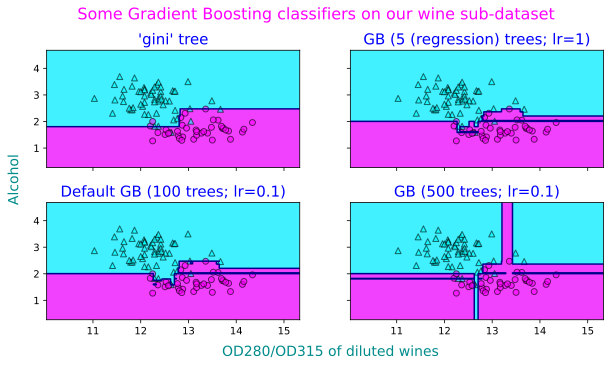

In [16]:
clf_gb_labels = ["'gini' tree", "GB (5 (regression) trees; lr=1)",
                 "Default GB (100 trees; lr=0.1)", "GB (500 trees; lr=0.1)"]

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

fig, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), [tree, gb_5_lr1, gb_def, gb_500], clf_gb_labels):
    ax = axarr[idx[0], idx[1]]
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap="cool", alpha=0.8)
    ax.contour(xx, yy, Z, levels=[0.5], colors="darkblue")
    ax.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], marker='^', color=cmap(0), alpha=0.6, edgecolor='black')
    ax.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], marker='o', color=cmap(0.999), alpha=0.6, edgecolor='black')
    ax.set_title(tt, fontsize=15, color='blue')
    
fig.subplots_adjust(top=.86, hspace=0.3)
fig.suptitle("Some Gradient Boosting classifiers on our wine sub-dataset", fontsize=16, color='magenta')
fig.text(0.52, 0.02, "OD280/OD315 of diluted wines", ha='center', va='center', fontsize=14, color='darkcyan')
fig.text(0.08, 0.5, "Alcohol", ha='center', va='center', fontsize=14, rotation=90, color='darkcyan')
plt.show()

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4c. scikit-learn's HistGradientBoostingClassifier</font><a id="4c"></a></p>$\quad$
        Still inside its <font color='#cc33ff'>ensemble</font> module, <font color='#cc33ff'>scikit-learn</font> offers the class <font color='#cc33ff'>HistGradientBoostingClassifier(loss='log_loss', learning_rate=0.1, max_iter=100, max_depth=None, max_leaf_nodes=31, min_samples_leaf=20, max_features=1.0, tol=1e-07, random_state=None)</font>. <font color='#cc33ff'>HistGradientBoostingClassifier</font> is a faster, more scalable variant of <font color='#cc33ff'>GradientBoostingClassifier</font> that speeds up training by binning continuous features into discrete intervals. It also supports native handling of missing values and categorical features. The parameters that I did not define in the previous subchapter for the <font color='#cc33ff'>GradientBoostingClassifier</font> are :<ul>
    <li><font color='#cc33ff'>max_iter=100</font> : the maximum number of <font color='#cc33ff'>boosting iterations</font> to perform; the maximum number of <font color='#cc33ff'>regression trees</font> to use is therefore <font color='#1aabff'>$K$</font>$\,\times\,$<font color='#5555ff'>max_iter</font> (<font color='#5555ff'>max_iter</font> in the binary classification case)</li>
    <li><font color='#cc33ff'>max_leaf_nodes=31</font> : the maximum number of leaves for each tree; if <font color='#cc33ff'>max_leaf_nodes=</font><font color='#1aabff'>None</font>, there is no maximum limit</li>
    <li><font color='#cc33ff'>max_features=1.0</font> : when <font color='#cc33ff'>max_features</font>$\,$<$\,$<font color='#1aabff'>1.0</font>, exactly <font color='#cc33ff'>$\text{int}($</font><font color='#1aabff'>$n$</font>$\,\times\,$<font color='#5555ff'>max_features</font><font color='#cc33ff'>$)$</font> features are randomly chosen at each node before splitting (<font color='#cc33ff'>$\text{int}$</font> being the integer part)</li>
    <li><font color='#cc33ff'>tol=1e-07</font> : at each iteration, the algorithm randomly chooses a validation set from the provided dataset; its <font color='#cc33ff'>$\text{log\_loss}$</font> is called the <font color='darkpink'>score</font>; when the absolute difference between the <font color='#cc33ff'>scores</font> obtained in two consecutive iterations is less than <font color='#cc33ff'>tol</font>, the algorithm stops; thus, the higher the <font color='#cc33ff'>tol</font>, the more likely we are to stop early</li>
    <li><font color='#cc33ff'>random_state=None</font> : the seed used by the random number generator; used here to perform the internal train/validation splits, and to select the features when <font color='#cc33ff'>max_features</font>$\,$<$\,$<font color='#1aabff'>1.0</font></li></ul>

<a id="Appendix"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>APPENDIX - ADABOOST AND GRADIENT BOOSTING REVISITED</font></h4>$\quad$
        Earlier, we presented the <font color='#cc33ff'>AdaBoost algorithm</font> (in "3. Adaptive boosting (AdaBoost)") and the <font color='#cc33ff'>gradient boosting algorithm</font> (in "4. Gradient Boosting"), and we tried them on the simplified version of the <font color='#cc33ff'>wine dataset</font> that the book uses. We noticed that this dataset was too simple, and the best predictions were already obtained when we used <font color='#cc33ff'>AdaBoost</font> with $3$ <font color='#cc33ff'>decision stumps</font> (trees of depth $1$) or <font color='#cc33ff'>gradient boosting</font> with $5$ <font color='#cc33ff'>decision trees of depth $3$</font>; using $500$ trees in both cases didn't yield a better classifier, in both cases. Therefore, here, I propose to introduce another dataset, sufficiently complicated to show these differences we were expecting to see.<br>$\quad$
        Since the <font color='#cc33ff'>AdaBoost algorithm</font> is a <font color='#cc33ff'>binary classifier</font>, while the <font color='#cc33ff'>gradient boosting algorithm</font> can deal with as many classes as we want, in order to compare their respective results, we will again use a $2$ classes dataset, but with more samples ($5000$ instead of $178$) and more noise. These criteria indicate to use a <font color='#cc33ff'>make_moons dataset</font>, which is built via the <font color='#cc33ff'>make_moons</font> function from <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>datasets</font> module (presented in part 3, "3c. Examples of soft margin linear classification (hyperplane and polynomial decision boundaries)")<br>$\quad$
        We begin with testing <font color='#cc33ff'>AdaBoost</font> (first the accuracy scores and then the <font color='#cc33ff'>decision regions</font>), and then we'll test <font color='#cc33ff'>gradient boosting</font> (idem).<br>$\quad$
        As I did earlier, in order to compare the results obtained by our ensemble algorithms with a good single classifier, I add an <font color='#cc33ff'>SVM</font> as a test model. As we saw, using an <font color='#cc33ff'>SVM</font> as a base learner takes time and is not reliable, so I removed the ensemble composed of $500$ <font color='#cc33ff'>SVM</font>. Since there are many points ($5000$), we can use a large <font color='#5555ff'>gamma</font> (recall that a large <font color='#5555ff'>gamma</font> corresponds to a narrow influence of each point - see part 3, "3d. Positive definite kernels and RKHS", "Examples of positive definite kernels" -, which results in decision boundaries close to the training points, which is good when there are many points, but prone to overfitting when we have fewer points); so we keep the <font color='#cc33ff'>gamma=</font><font color='#1aabff'>30</font> that we used earlier. And to avoid overfitting we use a stronger regularization, the default <font color='#cc33ff'>C=</font><font color='#1aabff'>1</font>.<br>$\quad$
        The results relative to <font color='#cc33ff'>AdaBoost</font> show that the best model is the fine-tuned <font color='#cc33ff'>SVM</font>, followed closely by the <font color='#cc33ff'>AdaBoost classifier</font> with $500$ <font color='#cc33ff'>entropy stumps</font> used in the book, which is itself slightly better than <font color='#cc33ff'>scikit-learn</font>'s default <font color='#cc33ff'>SVM</font> (<font color='#cc33ff'>training accuracies</font> : $92\%$, $91.85\%$ and $91.55\%$ resp.; <font color='#cc33ff'>test accuracies</font> : $90.7\%$, $90.3\%$ and $90.1\%$ resp.). Then I compare the parameter value <font color='#cc33ff'>criterion=</font><font color='#1aabff'>'entropy'</font> with the slightly simpler <font color='#cc33ff'>criterion=</font><font color='#1aabff'>'gini'</font>, which is the default in <font color='#cc33ff'>scikit-learn</font>; the results are almost exactly the same (training accuracies : $91.85\%$ and $91.72\%$ resp.; test accuracies : $90.3\%$ for both). Finally, I test the influence of the number of these default stumps; using only $50$ <font color='#cc33ff'>Gini stumps</font>, the results are clearly worse (training accuracy : $89.58\%$; test accuracy: $88.2\%$); while with only $3$ <font color='#cc33ff'>entropy stumps</font> we got lucky, and obtained better results than with $50$, which is not relevant except to show that <font color='#cc33ff'>AdaBoost</font> needs enough <font color='#cc33ff'>stumps</font> to yield reliable results, and that the default $50$ might not be enough.<br>$\quad$
        We then display the <font color='#cc33ff'>decision regions</font> of the three <font color='#cc33ff'>AdaBoost classifiers</font> built with <font color='#cc33ff'>Gini stumps</font>, together with the <font color='#cc33ff'>decision regions</font> of the fine-tuned <font color='#cc33ff'>SVM</font>. I only represent the first $200$ training points, so we can still see the <font color='#cc33ff'>decision boundaries</font>.<br>$\quad$
        The results relative to <font color='#cc33ff'>gradient boosting</font> will be presented below that.

In [17]:
from sklearn.datasets import make_moons

# Generate make_moons dataset with noise=0.3 and 500 instances
Xm, ym = make_moons(n_samples=5000, noise=0.3, random_state=1936)

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2, stratify=ym, random_state=1)

# the classifiers for AdaBoost
stump = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1)
# the 'tree' fit is not reused when fitting 'ada'
ada_3 = AdaBoostClassifier(n_estimators=3, random_state=1)
ada_def = AdaBoostClassifier(random_state=1)
ada_500 = AdaBoostClassifier(n_estimators=500, random_state=1)
ada_500_entr = AdaBoostClassifier(estimator=stump, n_estimators=500, random_state=1)
svm_g30_c1 = SVC(kernel='rbf', gamma=30, C=1, random_state=1)
svm_def = SVC(random_state=1)

classifiers = [
    ("Decision Tree (1 'entropy' stump)", stump),
    ("small AdaBoost (3 'gini' stumps)", ada_3),
    ("Default AdaBoost (50 'gini' stumps)", ada_def),
    ("large AdaBoost (500 'gini' stumps)", ada_500),
    ("AdaBoost (500 'entropy' stumps)", ada_500_entr),
    ("1 SVM with kernel='rbf', gamma=30, and C=1", svm_g30_c1),
    ("1 default SVM", svm_def)]

for clf_name, clf in classifiers:
    clf.fit(Xm_train, ym_train)
    ym_train_pred = clf.predict(Xm_train)
    ym_test_pred = clf.predict(Xm_test)
    train_accuracy = accuracy_score(ym_train, ym_train_pred)
    test_accuracy = accuracy_score(ym_test, ym_test_pred)
    print(BB + "\n", clf_name, GB + ":\ntraining accuracy :" + MB, f"{round(100*train_accuracy, 2)}%")
    print(GB + "test accuracy :" + MB, f"{round(100*test_accuracy, 2)}%")


 Decision Tree (1 'entropy' stump) :
training accuracy : 82.03%
test accuracy : 80.2%

 small AdaBoost (3 'gini' stumps) :
training accuracy : 90.0%
test accuracy : 89.0%

 Default AdaBoost (50 'gini' stumps) :
training accuracy : 89.58%
test accuracy : 88.2%

 large AdaBoost (500 'gini' stumps) :
training accuracy : 91.72%
test accuracy : 90.3%

 AdaBoost (500 'entropy' stumps) :
training accuracy : 91.85%
test accuracy : 90.3%

 1 SVM with kernel='rbf', gamma=30, and C=1 :
training accuracy : 92.0%
test accuracy : 90.7%

 1 default SVM :
training accuracy : 91.55%
test accuracy : 90.1%


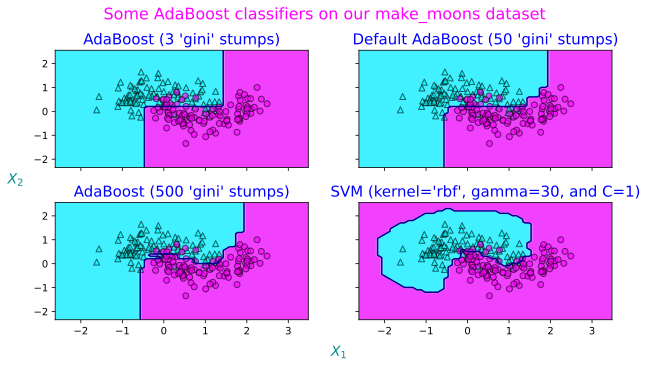

In [18]:
clf_ada_labels = ["AdaBoost (3 'gini' stumps)", "Default AdaBoost (50 'gini' stumps)",
                  "AdaBoost (500 'gini' stumps)", "SVM (kernel='rbf', gamma=30, and C=1)"]

# Only display the first 200 training points
Xm_display = Xm_train[:200]
ym_display = ym_train[:200]

x_min = Xm_display[:, 0].min() - 1
x_max = Xm_display[:, 0].max() + 1
y_min = Xm_display[:, 1].min() - 1
y_max = Xm_display[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

fig, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), [ada_3, ada_def, ada_500, svm_g30_c1], clf_ada_labels):
    ax = axarr[idx[0], idx[1]]
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap="cool", alpha=0.8)
    ax.contour(xx, yy, Z, levels=[0.5], colors="darkblue")
    ax.scatter(Xm_display[ym_display==0, 0], Xm_display[ym_display==0, 1], marker='^', color=cmap(0), alpha=0.6, edgecolor='black')
    ax.scatter(Xm_display[ym_display==1, 0], Xm_display[ym_display==1, 1], marker='o', color=cmap(0.999), alpha=0.6, edgecolor='black')
    ax.set_title(tt, fontsize=15, color='blue')

fig.subplots_adjust(top=.86, hspace=0.3)
fig.suptitle("Some AdaBoost classifiers on our make_moons dataset", fontsize=16, color='magenta')
fig.text(0.52, 0.02, "$X_1$", ha='center', va='center', fontsize=14, color='darkcyan')
fig.text(0.07, 0.5, "$X_2$", ha='center', va='center', fontsize=14, color='darkcyan')
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='#cc33ff'>Gradient boosting</font> manages to slightly improve the results obtained by the fine-tuned <font color='#cc33ff'>SVM</font> : when it uses $500$ <font color='#cc33ff'>regression trees</font> it has a better <font color='#cc33ff'>training accuracy</font> ($92.2\%$ vs $92\%$), and, more importantly, a better <font color='#cc33ff'>test accuracy</font> ($90.8\%$ vs $90.7\%$). Moreover, the same performance can be obtained with only $100$ <font color='#cc33ff'>regression trees</font>, as in <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>gradient boosting</font> default, but with a slightly smaller <font color='#cc33ff'>learning rate</font> (<font color='#cc33ff'>learning_rate=</font><font color='#1aabff'>$0.05$</font> instead of <font color='#cc33ff'>learning_rate=</font><font color='#1aabff'>$0.1$</font>). This illustrates the strength of <font color='#cc33ff'>ensemble learners</font>.

In [19]:
# the classifiers
tree = DecisionTreeClassifier(max_depth=3, random_state=1)
# the 'tree' fit is not reused when training the gradient boosting classifiers
gb_5_lr1 = GradientBoostingClassifier(n_estimators=5, learning_rate=1, random_state=1)
gb_def = GradientBoostingClassifier(learning_rate=0.1, random_state=1)
gb_100_lr005 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=1)
gb_500_lr001 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, random_state=1)
svm_g30_c1 = SVC(kernel='rbf', gamma=30, C=1, random_state=1)

classifiers = [
    ("Decision Tree (1 'gini' tree of depth 3)", tree),
    ("small Gradient Boosting (5 regression trees of depth 3; learning_rate=1)", gb_5_lr1),
    ("Default Gradient Boosting (100 regression trees of depth 3; learning_rate=0.1)", gb_def),
    ("medium Gradient Boosting (100 regression trees of depth 3; learning_rate=0.05)", gb_100_lr005),
    ("large Gradient Boosting (500 regression trees of depth 3; learning_rate=0.01)", gb_500_lr001),
    ("1 SVM with kernel='rbf', gamma=30, and C=1", svm_g30_c1)]

for clf_name, clf in classifiers:
    clf.fit(Xm_train, ym_train)
    ym_train_pred = clf.predict(Xm_train)
    ym_test_pred = clf.predict(Xm_test)
    train_accuracy = accuracy_score(ym_train, ym_train_pred)
    test_accuracy = accuracy_score(ym_test, ym_test_pred)
    print(BB + "\n", clf_name, GB + ":\ntraining accuracy :" + MB, f"{round(100*train_accuracy, 2)}%")
    print(GB + "test accuracy :" + MB, f"{round(100*test_accuracy, 2)}%")


 Decision Tree (1 'gini' tree of depth 3) :
training accuracy : 90.03%
test accuracy : 88.6%

 small Gradient Boosting (5 regression trees of depth 3; learning_rate=1) :
training accuracy : 92.1%
test accuracy : 90.4%

 Default Gradient Boosting (100 regression trees of depth 3; learning_rate=0.1) :
training accuracy : 92.95%
test accuracy : 90.1%

 medium Gradient Boosting (100 regression trees of depth 3; learning_rate=0.05) :
training accuracy : 92.2%
test accuracy : 90.8%

 large Gradient Boosting (500 regression trees of depth 3; learning_rate=0.01) :
training accuracy : 92.2%
test accuracy : 90.8%

 1 SVM with kernel='rbf', gamma=30, and C=1 :
training accuracy : 92.0%
test accuracy : 90.7%


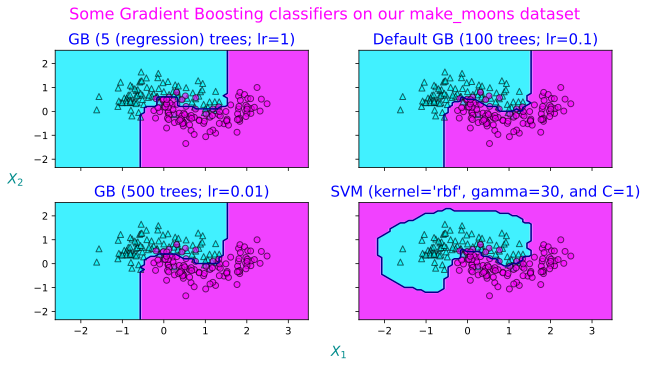

In [20]:
clf_gb_labels = ["GB (5 (regression) trees; lr=1)", "Default GB (100 trees; lr=0.1)",
                 "GB (500 trees; lr=0.01)", "SVM (kernel='rbf', gamma=30, and C=1)"]

# Only display the first 200 training points
Xm_display = Xm_train[:200]
ym_display = ym_train[:200]

x_min = Xm_display[:, 0].min() - 1
x_max = Xm_display[:, 0].max() + 1
y_min = Xm_display[:, 1].min() - 1
y_max = Xm_display[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

fig, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(10, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), [gb_5_lr1, gb_def, gb_500_lr001, svm_g30_c1], clf_gb_labels):
    ax = axarr[idx[0], idx[1]]
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap="cool", alpha=0.8)
    ax.contour(xx, yy, Z, levels=[0.5], colors="darkblue")
    ax.scatter(Xm_display[ym_display==0, 0], Xm_display[ym_display==0, 1], marker='^', color=cmap(0), alpha=0.6, edgecolor='black')
    ax.scatter(Xm_display[ym_display==1, 0], Xm_display[ym_display==1, 1], marker='o', color=cmap(0.999), alpha=0.6, edgecolor='black')
    ax.set_title(tt, fontsize=15, color='blue')

fig.subplots_adjust(top=.86, hspace=0.3)
fig.suptitle("Some Gradient Boosting classifiers on our make_moons dataset", fontsize=16, color='magenta')
fig.text(0.52, 0.02, "$X_1$", ha='center', va='center', fontsize=14, color='darkcyan')
fig.text(0.07, 0.5, "$X_2$", ha='center', va='center', fontsize=14, color='darkcyan')
plt.show()